In [1]:
import pandas as pd
import numpy as np
import time
import shap


import seaborn as sns
import matplotlib.pyplot as plt

from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LogisticRegression  
from sklearn.metrics import (
    f1_score, roc_auc_score, matthews_corrcoef,
    confusion_matrix, roc_curve, auc, recall_score, accuracy_score, precision_score
)
from sklearn.model_selection import GridSearchCV

from pycaret.classification import setup, compare_models

import optuna
import numpy as np
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from sklearn.utils.class_weight import compute_class_weight



In [2]:
df = pd.read_csv('weatherAUS.csv')

In [3]:
df_copia = df.copy()
df_copia.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


In [4]:
df_copia.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           145460 non-null  object 
 1   Location       145460 non-null  object 
 2   MinTemp        143975 non-null  float64
 3   MaxTemp        144199 non-null  float64
 4   Rainfall       142199 non-null  float64
 5   Evaporation    82670 non-null   float64
 6   Sunshine       75625 non-null   float64
 7   WindGustDir    135134 non-null  object 
 8   WindGustSpeed  135197 non-null  float64
 9   WindDir9am     134894 non-null  object 
 10  WindDir3pm     141232 non-null  object 
 11  WindSpeed9am   143693 non-null  float64
 12  WindSpeed3pm   142398 non-null  float64
 13  Humidity9am    142806 non-null  float64
 14  Humidity3pm    140953 non-null  float64
 15  Pressure9am    130395 non-null  float64
 16  Pressure3pm    130432 non-null  float64
 17  Cloud9am       89572 non-null

In [5]:
# Podemos ver que hay una gran cantidad de nulos
df_copia.isnull().sum()

Date                 0
Location             0
MinTemp           1485
MaxTemp           1261
Rainfall          3261
Evaporation      62790
Sunshine         69835
WindGustDir      10326
WindGustSpeed    10263
WindDir9am       10566
WindDir3pm        4228
WindSpeed9am      1767
WindSpeed3pm      3062
Humidity9am       2654
Humidity3pm       4507
Pressure9am      15065
Pressure3pm      15028
Cloud9am         55888
Cloud3pm         59358
Temp9am           1767
Temp3pm           3609
RainToday         3261
RainTomorrow      3267
dtype: int64

# **Ejercicio 1:** Clusterización en regiones

In [6]:
# Coordenadas aproximadas para todas las ciudades de Australia en el df
coordenadas_ciudades = {
    'Albury': (-36.08, 146.92),
    'Sydney': (-33.87, 151.21),
    'Melbourne': (-37.81, 144.96),
    'Brisbane': (-27.47, 153.02),
    'Perth': (-31.95, 115.86),
    'Adelaide': (-34.93, 138.60),
    'Darwin': (-12.46, 130.84),
    'Hobart': (-42.88, 147.33),
    'Canberra': (-35.28, 149.13),
    'MountGinini': (-35.53, 148.77),
    'GoldCoast': (-28.02, 153.40),
    'Wollongong': (-34.43, 150.89),
    'MountGambier': (-37.83, 140.78),
    'Launceston': (-41.44, 147.14),
    'AliceSprings': (-23.70, 133.88),
    'Albany': (-35.02, 117.88),
    'Townsville': (-19.26, 146.82),
    'Bendigo': (-36.76, 144.28),
    'Cairns': (-16.92, 145.77),
    'Ballarat': (-37.56, 143.85),
    'Penrith': (-33.75, 150.69),
    'Newcastle': (-32.93, 151.78),
    'Tuggeranong': (-35.42, 149.07),
    'PerthAirport': (-31.94, 115.97),
    'SalmonGums': (-32.98, 121.63),
    'Nhil': (-36.33, 141.65),
    'Katherine': (-14.47, 132.27),
    'Uluru': (-25.34, 131.03),
    'BadgerysCreek': (-33.92, 150.78),
    'Cobar': (-31.49, 145.83),
    'CoffsHarbour': (-30.30, 153.11),
    'Moree': (-29.46, 149.84),
    'NorahHead': (-33.28, 151.58),
    'NorfolkIsland': (-29.04, 167.95),
    'Richmond': (-33.60, 150.75),
    'SydneyAirport': (-33.94, 151.18),
    'WaggaWagga': (-35.12, 147.37),
    'Williamtown': (-32.79, 151.84),
    'Sale': (-38.11, 147.07),
    'MelbourneAirport': (-37.67, 144.84),
    'Mildura': (-34.19, 142.16),
    'Portland': (-38.34, 141.61),
    'Watsonia': (-37.71, 145.08),
    'Dartmoor': (-37.92, 141.27),
    'Nuriootpa': (-34.47, 138.99),
    'Woomera': (-31.15, 136.80),
    'Witchcliffe': (-34.00, 115.10),
    'PearceRAAF': (-31.67, 116.02),
    'Walpole': (-34.98, 116.73),
}


In [7]:
# Decidimos hacer un df con coordenadas de las ciudades de Australia 
# A partir de eso establecer fácilmente las regiones
coord_df = pd.DataFrame.from_dict(coordenadas_ciudades, orient='index', columns=['Latitud', 'Longitud'])
coord_df.reset_index(inplace=True)
coord_df.rename(columns={'index': 'Location'}, inplace=True)

# Unimos al dataset
df_merge = pd.merge(df_copia, coord_df, on='Location', how='left')


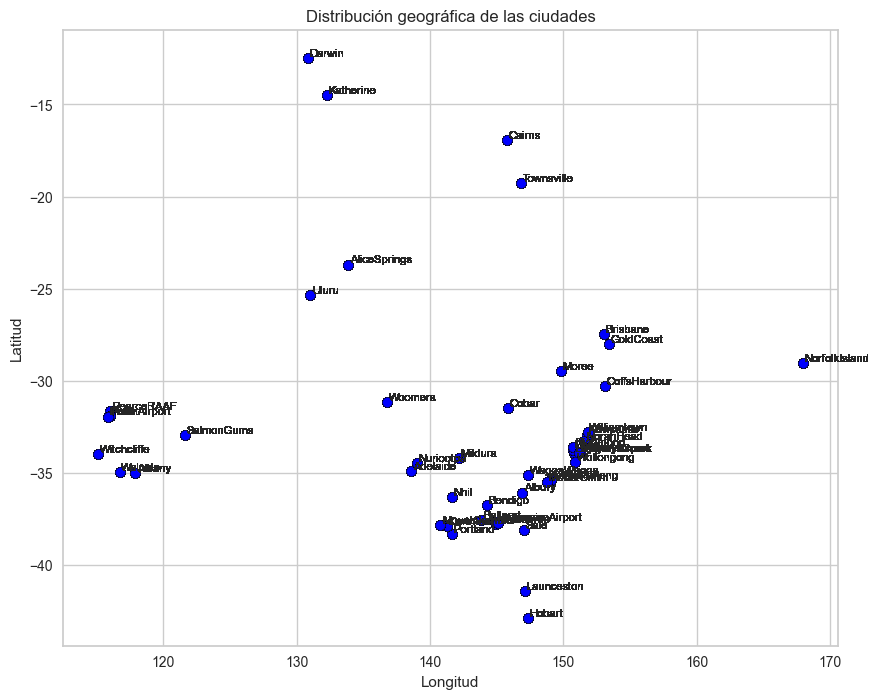

In [8]:
# Visualizamos los posibles clusters
plt.figure(figsize=(10, 8))
plt.scatter(df_merge['Longitud'], df_merge['Latitud'], c='blue', alpha=0.6, edgecolors='k')

for i, nombre in enumerate(df_merge['Location']):
    plt.text(df_merge['Longitud'].iloc[i] + 0.1, df_merge['Latitud'].iloc[i] + 0.1, nombre, fontsize=8)

plt.title('Distribución geográfica de las ciudades')
plt.xlabel('Longitud')
plt.ylabel('Latitud')
plt.grid(True)
plt.show()

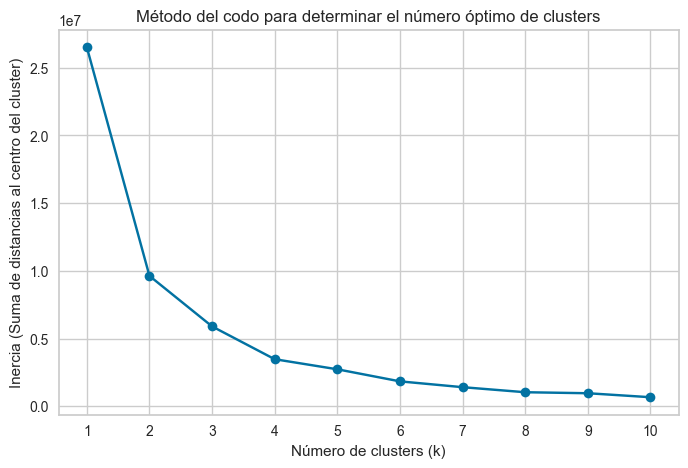

In [9]:
# Gafico del codo para saber el numero de clusters adecuado
X = df_merge[['Latitud', 'Longitud']]

# Guardar la suma de errores cuadráticos para cada k
inertias = []
k_range = range(1, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(X)
    inertias.append(kmeans.inertia_)

# Grafico
plt.figure(figsize=(8, 5))
plt.plot(k_range, inertias, marker='o')
plt.title('Método del codo para determinar el número óptimo de clusters')
plt.xlabel('Número de clusters (k)')
plt.ylabel('Inercia (Suma de distancias al centro del cluster)')
plt.xticks(k_range)
plt.grid(True)
plt.show()

In [10]:
# Hacemos k-means
k = 4  # Número de clusters
kmeans = KMeans(n_clusters=k, random_state=42)
df_merge['Region'] = kmeans.fit_predict(X)

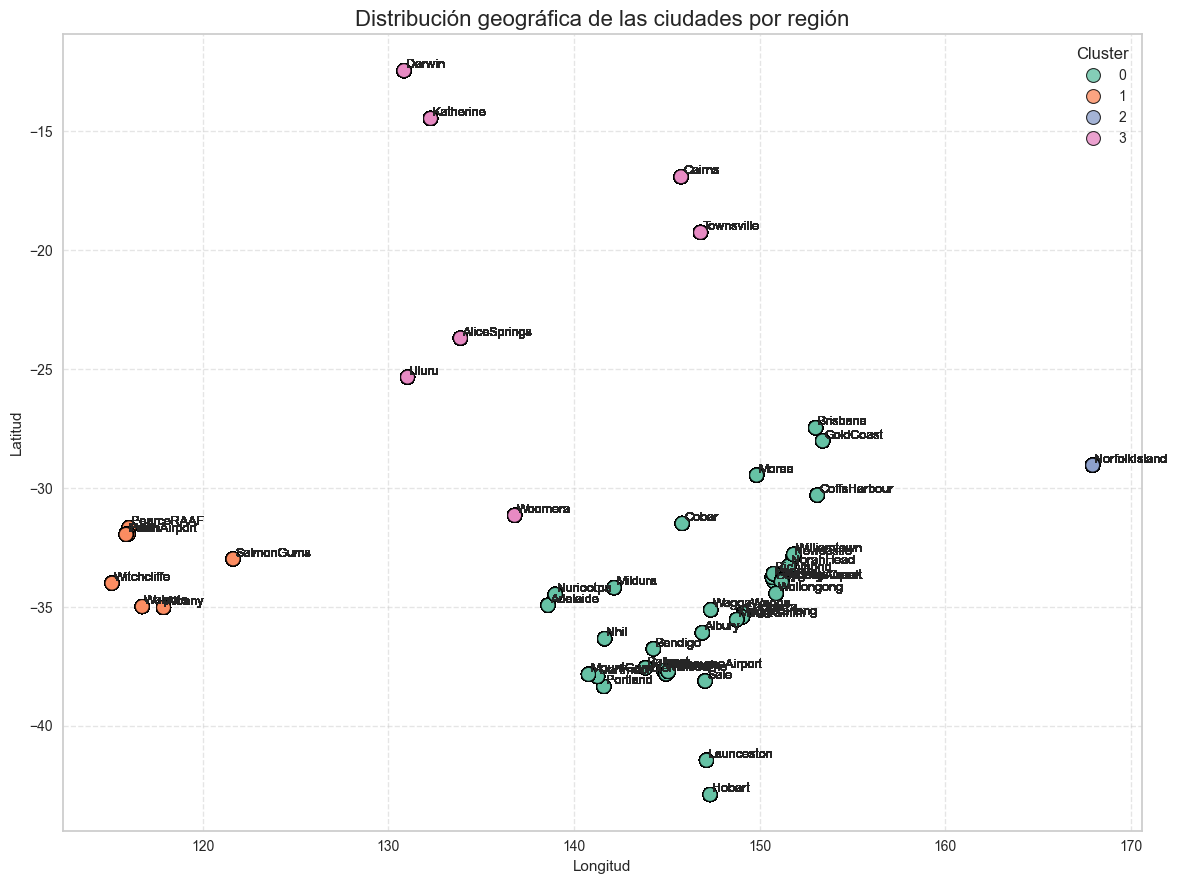

In [11]:
plt.figure(figsize=(12, 9))

sns.scatterplot(
    data=df_merge,
    x='Longitud',
    y='Latitud',
    hue='Region',              
    palette='Set2',            
    s=100,                    
    edgecolor='black',         
    alpha=0.8
)

# Etiquetamos cada ciudad
for i, fila in df_merge.iterrows():
    plt.text(
        fila['Longitud'] + 0.1,
        fila['Latitud'] + 0.1,
        fila['Location'],
        fontsize=9,
        alpha=0.7
    )

plt.title('Distribución geográfica de las ciudades por región', fontsize=16)
plt.xlabel('Longitud')
plt.ylabel('Latitud')
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(title='Cluster', loc='best')
plt.tight_layout()
plt.show()

# **Ejercicio 2:** Análisis descriptivo

### **Descripción de las variables** 

#### Variables categóricas

- **Location**: Ciudad australiana donde se tomó la observación.
- **WindGustDir**: Dirección del viento más fuerte del día.
- **WindDir9am**: Dirección del viento a las 9:00 horas.
- **WindDir3pm**: Dirección del viento a las 15:00 horas.
- **Cloud9am**: Cobertura nubosa a las 9:00 horas (escala de 0 a 9). 
- **Cloud3pm**: Cobertura nubosa a las 15:00 horas (escala de 0 a 9). 
- **RainToday**: Indica si llovió el día actual ("Yes"/"No").
- **RainTomorrow**: Variable objetivo. Indica si lloverá al día siguiente ("Yes"/"No").
- **Region**: Indica a que region pertenece el registro

#### Variables numéricas

- **MinTemp**: Temperatura mínima registrada durante el día (°C).
- **MaxTemp**: Temperatura máxima registrada durante el día (°C).
- **Rainfall**: Cantidad de lluvia caída durante el día (mm).
- **Evaporation**: Cantidad de agua evaporada durante el día (mm).
- **Sunshine**: Cantidad de horas de sol registradas en el día.
- **WindGustSpeed**: Velocidad del viento más fuerte registrado (km/h).
- **WindSpeed9am**: Velocidad del viento a las 9:00 horas (km/h).
- **WindSpeed3pm**: Velocidad del viento a las 15:00 horas (km/h).
- **Humidity9am**: Humedad relativa a las 9:00 horas (%).
- **Humidity3pm**: Humedad relativa a las 15:00 horas (%).
- **Pressure9am**: Presión atmosférica a las 9:00 horas (hPa).
- **Pressure3pm**: Presión atmosférica a las 15:00 horas (hPa).
- **Temp9am**: Temperatura a las 9:00 horas (°C).
- **Temp3pm**: Temperatura a las 15:00 horas (°C).

#### Variable temporal

- **Date**: Fecha en la que se registraron las mediciones climáticas. 

### **Eliminamos columnas innecesarias y registros con nulos relevantes**

In [12]:
# Eliminamos las columnas de coordenadas que utilizamos para crear las regiones
df_2 = df_merge.drop(columns=['Latitud', 'Longitud', 'Location'])

In [13]:
# Creamos una nueva columna Month --> Consideramos que es lo más relevante de Date
df_2['Date'] = pd.to_datetime(df_2['Date'])
df_2["Month"] = df_2["Date"].dt.month


In [14]:
df_2 = df_2.drop('Date', axis=1)

In [15]:
# Eliminamos las filas donde la variable objetivo es nula
df_2 = df_2.dropna(subset=['RainTomorrow'])

In [16]:
# Eliminamos las filas donde la mayoria (60%) de los datos son nulos. 
# Conservarlos podria ocasionar un ruido o sesgos en su posterior imputacion
df_2['null_count'] = df_2.isnull().sum(axis=1)
df_2 = df_2[df_2['null_count'] < 13].copy()

In [17]:
cant_filas_originales = df_merge.shape[0]
cant_filas_finales = df_2.shape[0]
print(f'Cantidad de filas eliminadas: {cant_filas_originales - cant_filas_finales}')

Cantidad de filas eliminadas: 3626


### **Balanceo del dataset**

In [18]:
df_2['RainTomorrow'].value_counts()

RainTomorrow
No     110054
Yes     31780
Name: count, dtype: int64

In [19]:
porcentajes = df_2['RainTomorrow'].value_counts(normalize=True) * 100
print(porcentajes)

RainTomorrow
No     77.593525
Yes    22.406475
Name: proportion, dtype: float64


El dataset no está balanceado. Podemos observar que la mayoría de los registros corresponden a días en los que no llueve.

Esta pregunta es relevante porque, al entrenar modelos de clasificación, es fundamental conocer si existe un desbalance entre las clase ya que cuando una clase es mucho más frecuente que la otra, el modelo puede aprender a predecir siempre la clase mayoritaria, logrando una aparente alta precisión, pero sin ser realmente útil.

Conocer el desbalance nos permite elegir métricas adecuadas de evaluación y usar modelos o tomar decisisones adecuadas para manejar este tipo de situaciones y así, conseguir un modelo que logre predecir correctamente tanto los días con lluvia como los días sin lluvia.

In [20]:
df_2['Cloud9am'].value_counts()

Cloud9am
7.0    19743
1.0    15552
8.0    14374
0.0     8576
6.0     8062
2.0     6437
3.0     5850
5.0     5506
4.0     4372
9.0        2
Name: count, dtype: int64

Al tener unicamente dos registros 9.0, puede ocurrir que esos dos registros al hacer la particion de datos queden de un lado. Es decir, puede que queden los dos en train o los dos en test. Esto al hacer la codificacion puede afectar ya que generaría una columna mas en train o test. Por ello los imputamos por 8 ya que es el valor más cercano

In [21]:
df_2['Cloud9am'] = df_2['Cloud9am'].replace(9.0, 8.0)

### **Partición de los Datos**

In [22]:
# Definimos las features relevantes 
features = ['Region','Month','MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustSpeed',
'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Temp9am', 'Temp3pm', 'WindGustDir',
'WindDir9am', 'WindDir3pm','Cloud9am', 'Cloud3pm','RainToday']

target = 'RainTomorrow'

# Separamos el dataset en train y test
X_train, X_test, y_train, y_test = train_test_split(df_2[features], df_2[target], test_size=0.2, random_state=42)

### **Imputación de los Datos**

#### Impuación variable numéricas --> Mediana

No se utilizó KNN vecinos ya que tiene un costo computacional muy alto.

Se eligió tratar de llenar el valor faltante de forma más adecuada posible, esto lo inferimos obteniendo la mediana para cada mes.
En datos de clima, por ejemplo, las temperaturas de enero podrían ser muy diferentes a las de julio, por lo que rellenar con la mediana o moda general (sin considerar el mes) no reflejaría adecuadamente las diferencias estacionales; agrupar por mes y reemplazar según ese grupo permite que los valores faltantes se llenen con algo que es más representativo del contexto temporal del dato faltante.

In [23]:
columnas_numericas = ['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustSpeed',
            'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am',
            'Pressure3pm', 'Temp9am', 'Temp3pm']

# Función para imputar por mediana mensual
def imputar_por_mediana_mensual(df, columnas, columna_mes):
    for col in columnas:
        df[col] = df.groupby(columna_mes)[col].transform(lambda x: x.fillna(x.median()))
    return df

# Imputamos en train y test
X_train = imputar_por_mediana_mensual(X_train, columnas_numericas, 'Month')
X_test = imputar_por_mediana_mensual(X_test, columnas_numericas, 'Month')

In [24]:
# Podemos ver que ya no hay nulos en las columnas numéricas
X_test[['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustSpeed',
            'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am',
            'Pressure3pm', 'Temp9am', 'Temp3pm']].isnull().sum()

MinTemp          0
MaxTemp          0
Rainfall         0
Evaporation      0
Sunshine         0
WindGustSpeed    0
WindSpeed9am     0
WindSpeed3pm     0
Humidity9am      0
Humidity3pm      0
Pressure9am      0
Pressure3pm      0
Temp9am          0
Temp3pm          0
dtype: int64

#### Imputacion variables categóricas --> RandomForest

Para imputar las variables categóricas optamos por utilizar Random Forest, ya que este método permite estimar valores faltantes considerando múltiples variables a la vez y capturando relaciones complejas entre ellas lo cual mejora la precisión de la imputación.

In [25]:
columnas_categoricas = ['WindGustDir', 'WindDir9am', 'WindDir3pm', 'Cloud9am', 'Cloud3pm', 'RainToday']

def imputar_categorica_rf(df, columna_objetivo, columnas_predictoras):
    """
    Imputa valores faltantes en una columna categórica usando RandomForestClassifier.
    
    Parámetros:
    - df: DataFrame con los datos
    - columna_objetivo: str, nombre de la columna categórica a imputar
    - columnas_predictoras: list[str], columnas numéricas sin nulos que se usan para predecir
    
    Retorna:
    - df_imputado: una copia del DataFrame original con la columna imputada
    """
    df_copy = df.copy()

    # Máscara de valores conocidos y faltantes
    mask_not_null = df_copy[columna_objetivo].notnull()
    mask_null = df_copy[columna_objetivo].isnull()

    # Si no hay valores faltantes, devolvemos el DataFrame sin hacer nada
    if mask_null.sum() == 0:
        return df_copy

    # Entrenamos el modelo con registros completos
    X_train_rf = df_copy.loc[mask_not_null, columnas_predictoras]
    y_train_rf = df_copy.loc[mask_not_null, columna_objetivo]

    # Validación extra: si hay nulos en X_train_rf, el modelo fallará
    if X_train_rf.isnull().any().any():
        raise ValueError(f"Hay nulos en las columnas predictoras al entrenar para '{columna_objetivo}'")

    modelo_rf = RandomForestClassifier(n_estimators=100, random_state=42)
    modelo_rf.fit(X_train_rf, y_train_rf)

    # Conjunto de predicción
    X_pred_rf = df_copy.loc[mask_null, columnas_predictoras]

    # Si no hay datos para predecir, no hacemos nada
    if X_pred_rf.empty:
        return df_copy

    predicciones = modelo_rf.predict(X_pred_rf)
    df_copy.loc[mask_null, columna_objetivo] = predicciones

    return df_copy

for col_cat in columnas_categoricas:
    X_train = imputar_categorica_rf(X_train, col_cat, columnas_numericas)
    X_test = imputar_categorica_rf(X_test, col_cat, columnas_numericas)


In [26]:
# Podemos ver que ya no hay nulos en las columnas categóricas
X_train[['WindGustDir', 'WindDir9am', 'WindDir3pm', 'Cloud9am', 'Cloud3pm', 'RainToday']].isnull().sum()

WindGustDir    0
WindDir9am     0
WindDir3pm     0
Cloud9am       0
Cloud3pm       0
RainToday      0
dtype: int64

In [27]:
X_test[['WindGustDir', 'WindDir9am', 'WindDir3pm', 'Cloud9am', 'Cloud3pm', 'RainToday']].isnull().sum()

WindGustDir    0
WindDir9am     0
WindDir3pm     0
Cloud9am       0
Cloud3pm       0
RainToday      0
dtype: int64

### **Visualizacion de Datos**

#### Variable temperatura máxima y mínima

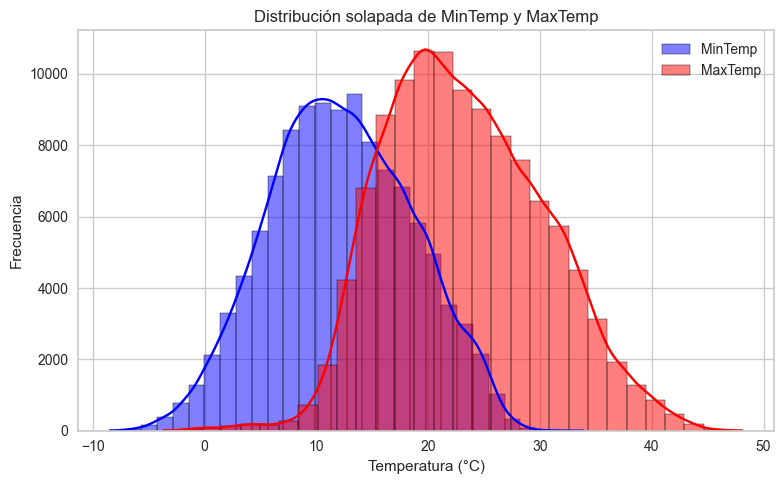

In [28]:
plt.figure(figsize=(8, 5))

sns.histplot(data=X_train, x='MinTemp', bins=30, color='blue', label='MinTemp', kde=True, alpha=0.5)
sns.histplot(data=X_train, x='MaxTemp', bins=30, color='red', label='MaxTemp', kde=True, alpha=0.5)

plt.title('Distribución solapada de MinTemp y MaxTemp')
plt.xlabel('Temperatura (°C)')
plt.ylabel('Frecuencia')
plt.legend()
plt.tight_layout()
plt.show()

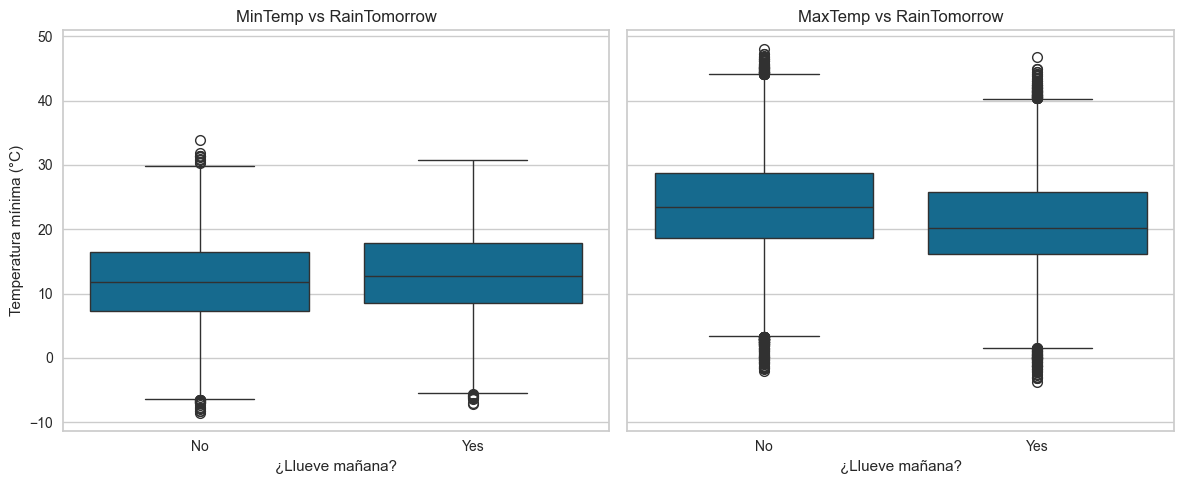

In [29]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

# Boxplot MinTemp
sns.boxplot(data=X_train.join(y_train), x='RainTomorrow', y='MinTemp', ax=axes[0])
axes[0].set_title('MinTemp vs RainTomorrow')
axes[0].set_xlabel('¿Llueve mañana?')
axes[0].set_ylabel('Temperatura mínima (°C)')

# Boxplot MaxTemp
sns.boxplot(data=X_train.join(y_train), x='RainTomorrow', y='MaxTemp', ax=axes[1])
axes[1].set_title('MaxTemp vs RainTomorrow')
axes[1].set_xlabel('¿Llueve mañana?')
axes[1].set_ylabel('')

plt.tight_layout()
plt.show()

#### Variable Presión

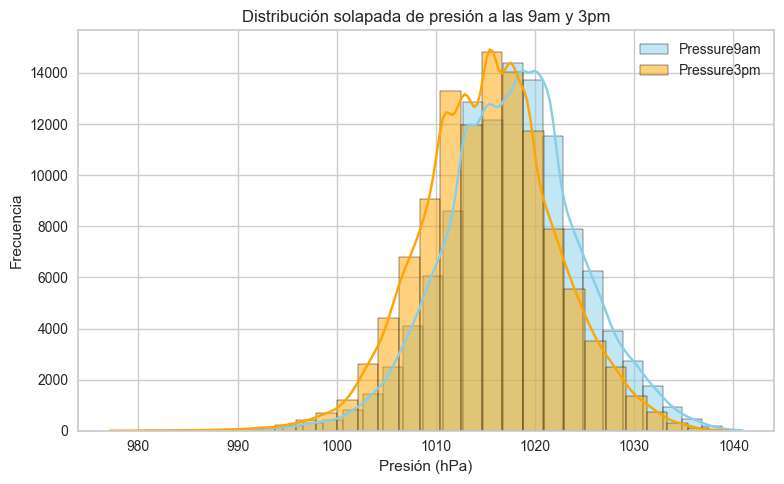

In [30]:
plt.figure(figsize=(8, 5))

sns.histplot(data=X_train, x='Pressure9am', bins=30, color='skyblue', label='Pressure9am', kde=True, alpha=0.5)
sns.histplot(data=X_train, x='Pressure3pm', bins=30, color='orange', label='Pressure3pm', kde=True, alpha=0.5)

plt.title('Distribución solapada de presión a las 9am y 3pm')
plt.xlabel('Presión (hPa)')
plt.ylabel('Frecuencia')
plt.legend()
plt.tight_layout()
plt.show()

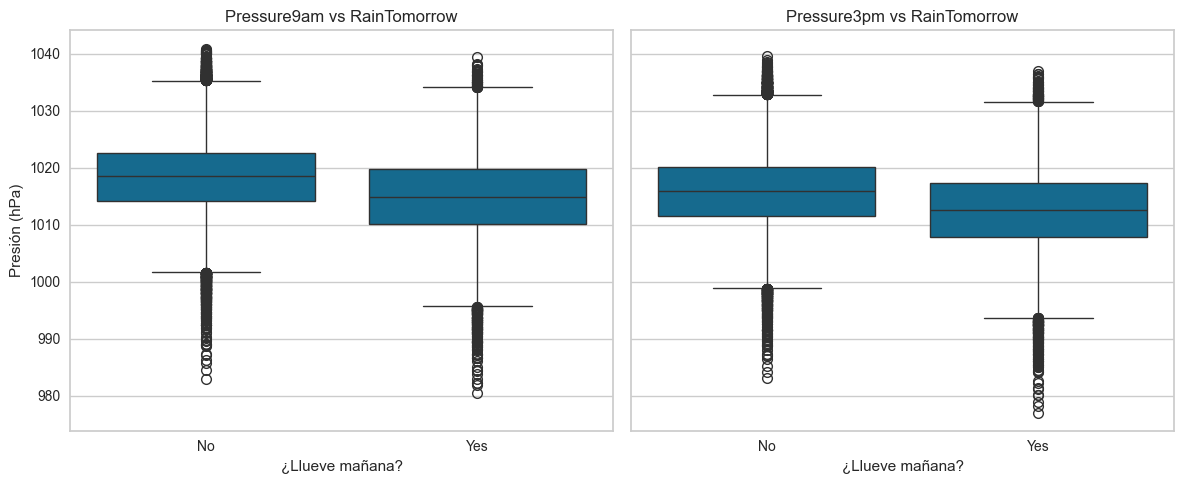

In [31]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

# Boxplot Pressure9am
sns.boxplot(data=X_train.join(y_train), x='RainTomorrow', y='Pressure9am', ax=axes[0])
axes[0].set_title('Pressure9am vs RainTomorrow')
axes[0].set_xlabel('¿Llueve mañana?')
axes[0].set_ylabel('Presión (hPa)')

# Boxplot Pressure3pm
sns.boxplot(data=X_train.join(y_train), x='RainTomorrow', y='Pressure3pm', ax=axes[1])
axes[1].set_title('Pressure3pm vs RainTomorrow')
axes[1].set_xlabel('¿Llueve mañana?')
axes[1].set_ylabel('')

plt.tight_layout()
plt.show()

#### Variable Velocidad del viento máxima

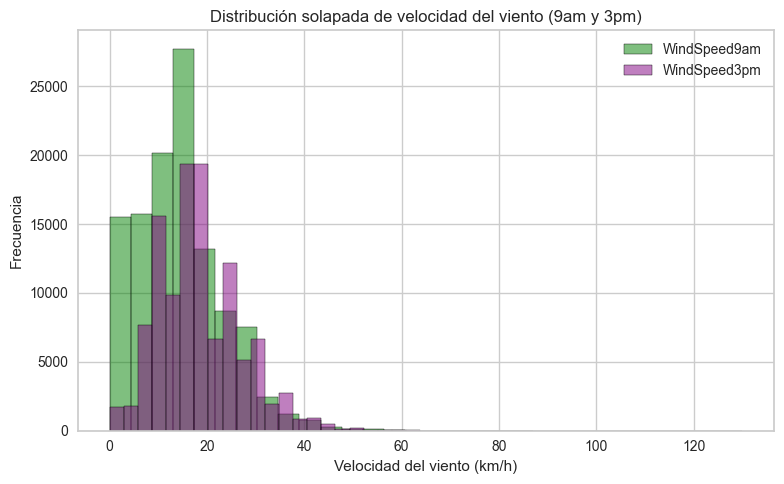

In [32]:
plt.figure(figsize=(8, 5))

sns.histplot(data=X_train, x='WindSpeed9am', bins=30, color='green', label='WindSpeed9am', alpha=0.5)
sns.histplot(data=X_train, x='WindSpeed3pm', bins=30, color='purple', label='WindSpeed3pm', alpha=0.5)

plt.title('Distribución solapada de velocidad del viento (9am y 3pm)')
plt.xlabel('Velocidad del viento (km/h)')
plt.ylabel('Frecuencia')
plt.legend()
plt.tight_layout()
plt.show()

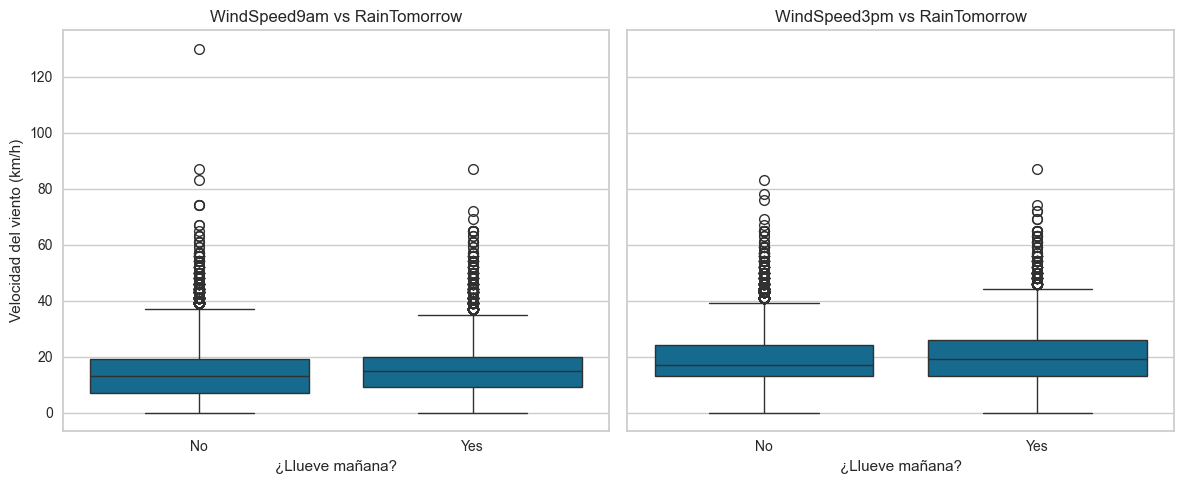

In [33]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

# Boxplot WindSpeed9am
sns.boxplot(data=X_train.join(y_train), x='RainTomorrow', y='WindSpeed9am', ax=axes[0])
axes[0].set_title('WindSpeed9am vs RainTomorrow')
axes[0].set_xlabel('¿Llueve mañana?')
axes[0].set_ylabel('Velocidad del viento (km/h)')

# Boxplot WindSpeed3pm
sns.boxplot(data=X_train.join(y_train), x='RainTomorrow', y='WindSpeed3pm', ax=axes[1])
axes[1].set_title('WindSpeed3pm vs RainTomorrow')
axes[1].set_xlabel('¿Llueve mañana?')
axes[1].set_ylabel('')

plt.tight_layout()
plt.show()

#### Variable Dirección del viento

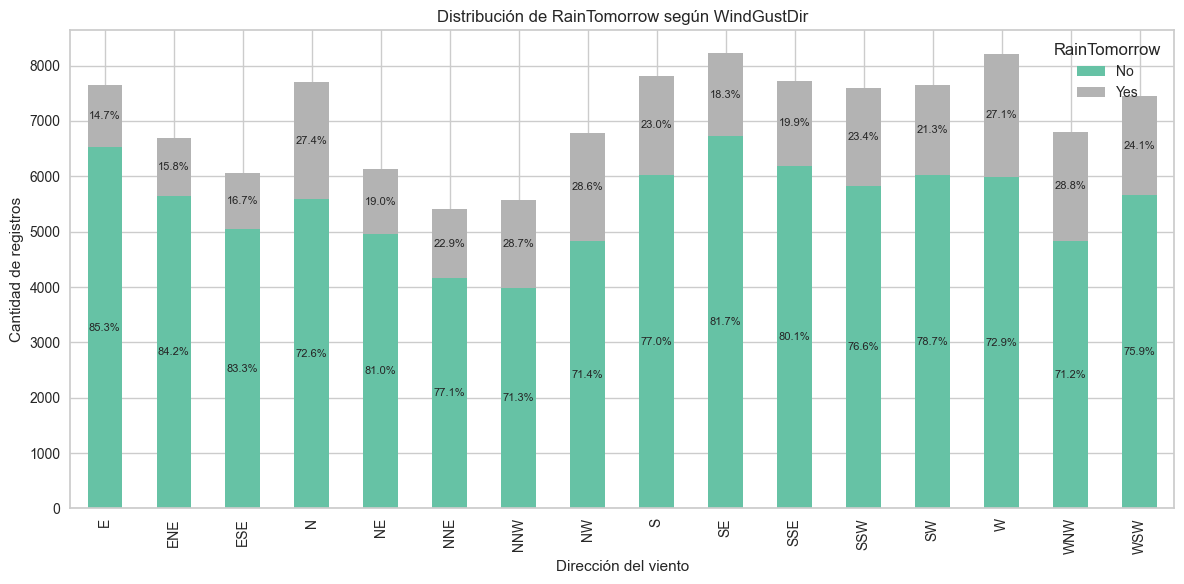

In [34]:
# Agrupamos y calculamos porcentajes
wind_target = X_train.join(y_train).groupby(['WindGustDir', 'RainTomorrow']).size().unstack(fill_value=0)
wind_target_pct = wind_target.div(wind_target.sum(axis=1), axis=0) * 100  

# Plot apilado
ax = wind_target.plot(kind='bar', stacked=True, figsize=(12, 6), colormap='Set2')
plt.title('Distribución de RainTomorrow según WindGustDir')
plt.xlabel('Dirección del viento')
plt.ylabel('Cantidad de registros')
plt.legend(title='RainTomorrow')
plt.tight_layout()

for i, dir_label in enumerate(wind_target.index):
    total = wind_target.loc[dir_label].sum()
    y_offset = 0
    for rain_value in ['No', 'Yes']:
        count = wind_target.loc[dir_label, rain_value]
        pct = wind_target_pct.loc[dir_label, rain_value]
        ax.text(i, y_offset + count / 2, f'{pct:.1f}%', ha='center', va='center', fontsize=8)
        y_offset += count

plt.show()

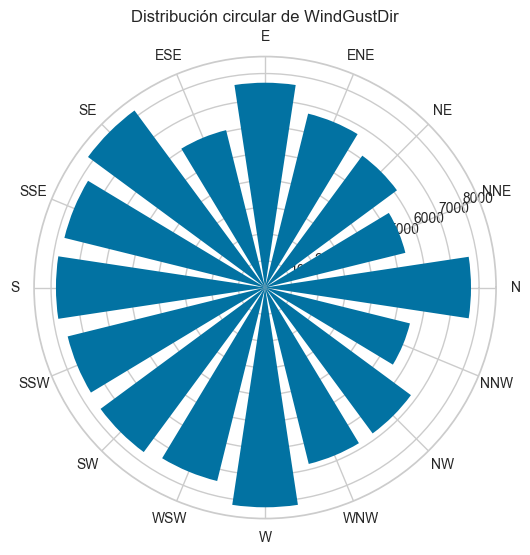

In [35]:

counts = X_train['WindGustDir'].value_counts().sort_index()
directions = ['N', 'NNE', 'NE', 'ENE', 'E', 'ESE', 'SE', 'SSE', 
              'S', 'SSW', 'SW', 'WSW', 'W', 'WNW', 'NW', 'NNW']

# Ángulos en radianes
angles = np.linspace(0, 2*np.pi, len(directions), endpoint=False)
counts = counts.reindex(directions, fill_value=0)

# Gráfico polar
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111, polar=True)
bars = ax.bar(angles, counts.values, width=0.3)
ax.set_xticks(angles)
ax.set_xticklabels(directions)
plt.title('Distribución circular de WindGustDir')
plt.show()


#### Variable Sunshine

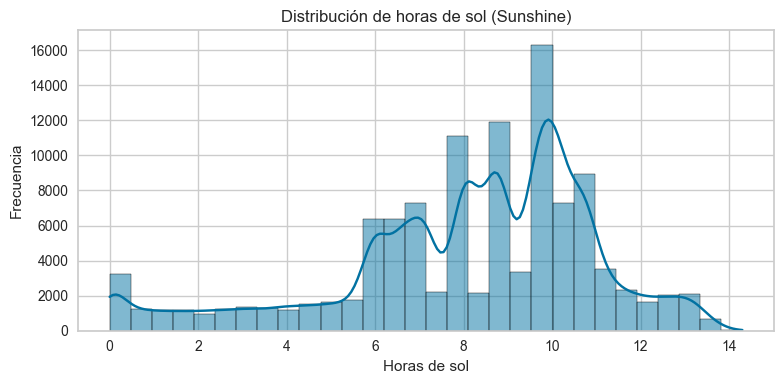

In [36]:
plt.figure(figsize=(8, 4))
sns.histplot(data=X_train, x='Sunshine', bins=30, kde=True)
plt.title('Distribución de horas de sol (Sunshine)')
plt.xlabel('Horas de sol')
plt.ylabel('Frecuencia')
plt.tight_layout()
plt.show()

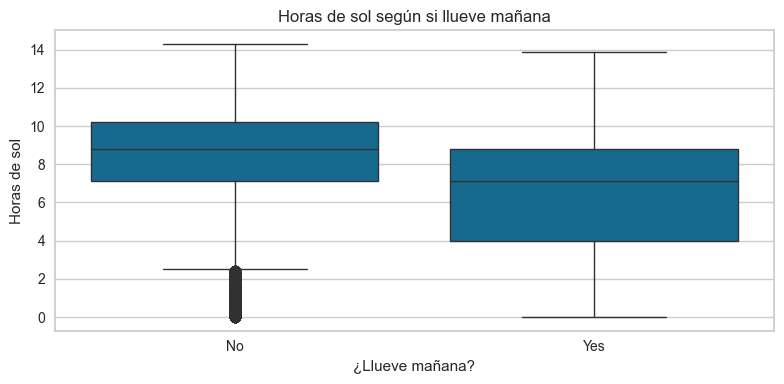

In [37]:
plt.figure(figsize=(8, 4))
sns.boxplot(data=X_train.join(y_train), x='RainTomorrow', y='Sunshine')
plt.title('Horas de sol según si llueve mañana')
plt.xlabel('¿Llueve mañana?')
plt.ylabel('Horas de sol')
plt.tight_layout()
plt.show()

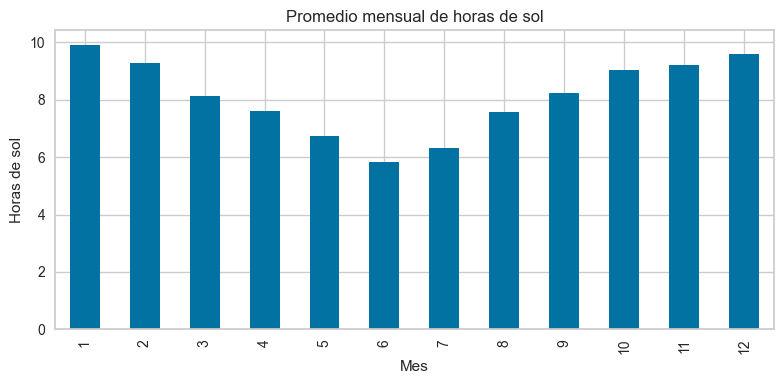

In [38]:
sol_por_mes = X_train.groupby('Month')['Sunshine'].mean()

plt.figure(figsize=(8, 4))
sol_por_mes.plot(kind='bar')
plt.title('Promedio mensual de horas de sol')
plt.xlabel('Mes')
plt.ylabel('Horas de sol')
plt.tight_layout()
plt.show()

#### Variable Mes

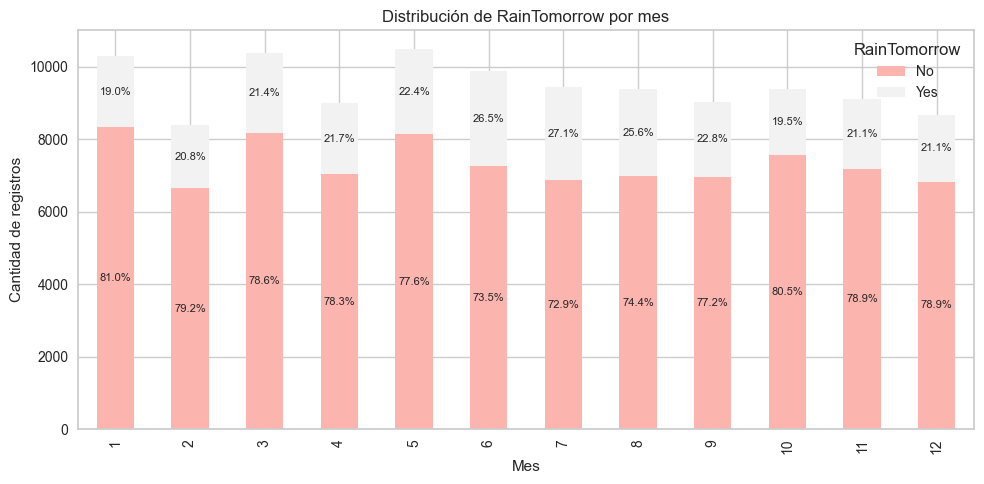

In [39]:
month_target = X_train.join(y_train).groupby(['Month', 'RainTomorrow']).size().unstack(fill_value=0)
 
month_target_pct = month_target.div(month_target.sum(axis=1), axis=0) * 100

ax = month_target.plot(kind='bar', stacked=True, figsize=(10, 5), colormap='Pastel1')
plt.title('Distribución de RainTomorrow por mes')
plt.xlabel('Mes')
plt.ylabel('Cantidad de registros')
plt.legend(title='RainTomorrow')

for i, mes in enumerate(month_target.index):
    total = month_target.loc[mes].sum()
    y_offset = 0
    for lluvia in ['No', 'Yes']:
        count = month_target.loc[mes, lluvia]
        pct = month_target_pct.loc[mes, lluvia]
        ax.text(i, y_offset + count / 2, f'{pct:.1f}%', ha='center', va='center', fontsize=8)
        y_offset += count

plt.tight_layout()
plt.show()

#### Variable Región

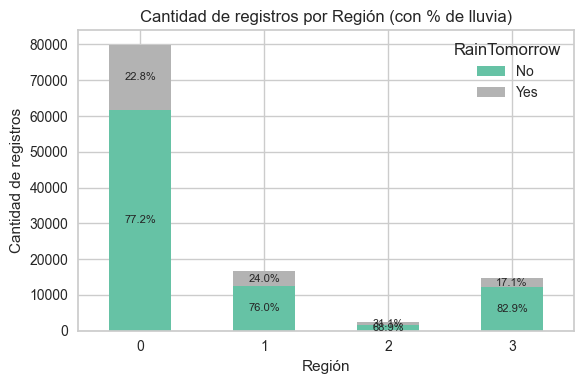

In [40]:
region_target_counts = X_train.join(y_train).groupby(['Region', 'RainTomorrow']).size().unstack(fill_value=0)

region_target_pct = region_target_counts.div(region_target_counts.sum(axis=1), axis=0) * 100

ax = region_target_counts.plot(kind='bar', stacked=True, figsize=(6, 4), colormap='Set2')
plt.title('Cantidad de registros por Región (con % de lluvia)')
plt.xlabel('Región')
plt.ylabel('Cantidad de registros')
plt.xticks(rotation=0)
plt.legend(title='RainTomorrow')
plt.tight_layout()

for i, region in enumerate(region_target_counts.index):
    total = region_target_counts.loc[region].sum()
    y_offset = 0
    for clase in ['No', 'Yes']:
        altura = region_target_counts.loc[region, clase]
        pct = region_target_pct.loc[region, clase]
        ax.text(i, y_offset + altura / 2, f'{pct:.1f}%', ha='center', va='center', fontsize=8)
        y_offset += altura

plt.show()

#### Variable Humedad

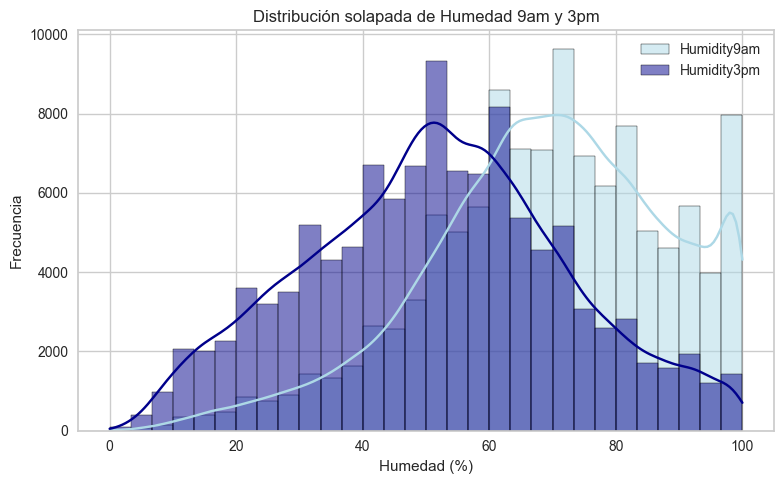

In [41]:
plt.figure(figsize=(8, 5))
sns.histplot(data=X_train, x='Humidity9am', bins=30, color='lightblue', label='Humidity9am', kde=True, alpha=0.5)
sns.histplot(data=X_train, x='Humidity3pm', bins=30, color='darkblue', label='Humidity3pm', kde=True, alpha=0.5)
plt.title('Distribución solapada de Humedad 9am y 3pm')
plt.xlabel('Humedad (%)')
plt.ylabel('Frecuencia')
plt.legend()
plt.tight_layout()
plt.show()

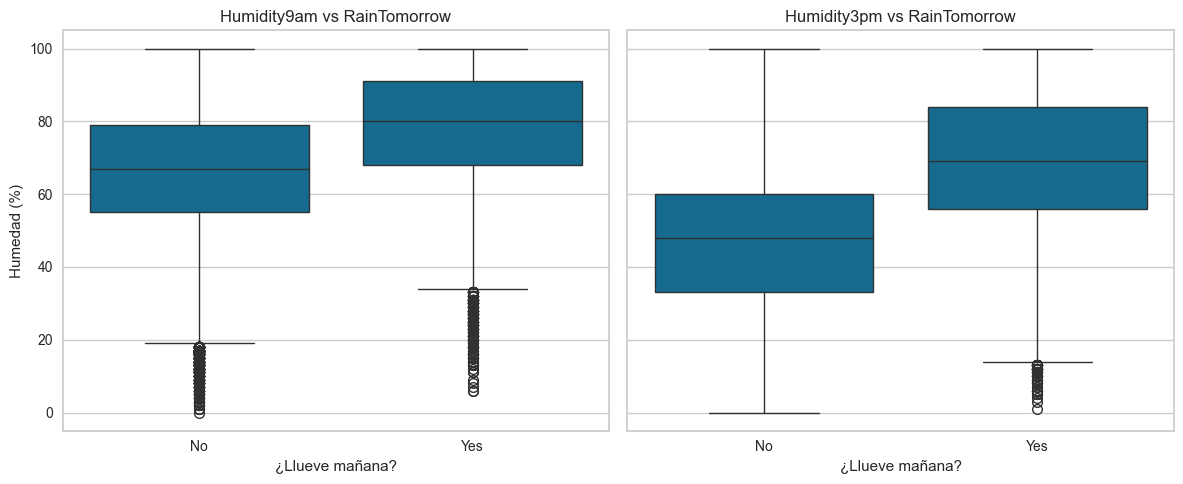

In [42]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

sns.boxplot(data=X_train.join(y_train), x='RainTomorrow', y='Humidity9am', ax=axes[0])
axes[0].set_title('Humidity9am vs RainTomorrow')

sns.boxplot(data=X_train.join(y_train), x='RainTomorrow', y='Humidity3pm', ax=axes[1])
axes[1].set_title('Humidity3pm vs RainTomorrow')

for ax in axes:
    ax.set_xlabel('¿Llueve mañana?')
    ax.set_ylabel('Humedad (%)')

plt.tight_layout()
plt.show()

#### Variable Nubosidad

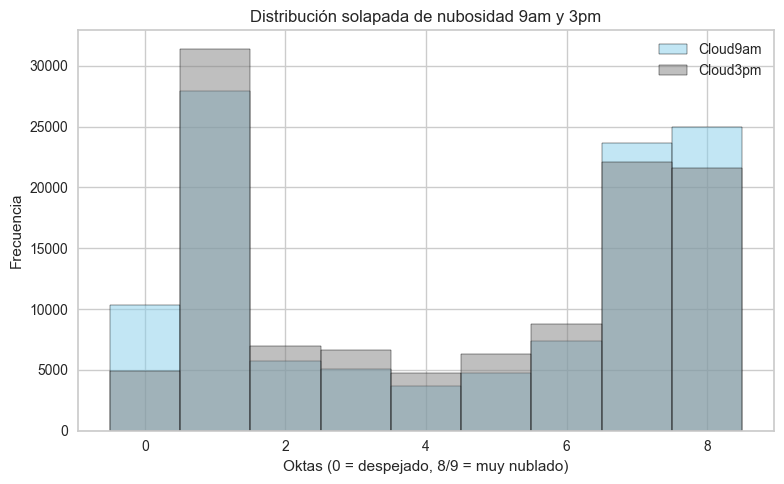

In [43]:
plt.figure(figsize=(8, 5))
sns.histplot(data=X_train, x='Cloud9am', bins=10, color='skyblue', label='Cloud9am', alpha=0.5, discrete=True)
sns.histplot(data=X_train, x='Cloud3pm', bins=10, color='gray', label='Cloud3pm', alpha=0.5, discrete=True)
plt.title('Distribución solapada de nubosidad 9am y 3pm')
plt.xlabel('Oktas (0 = despejado, 8/9 = muy nublado)')
plt.ylabel('Frecuencia')
plt.legend()
plt.tight_layout()
plt.show()

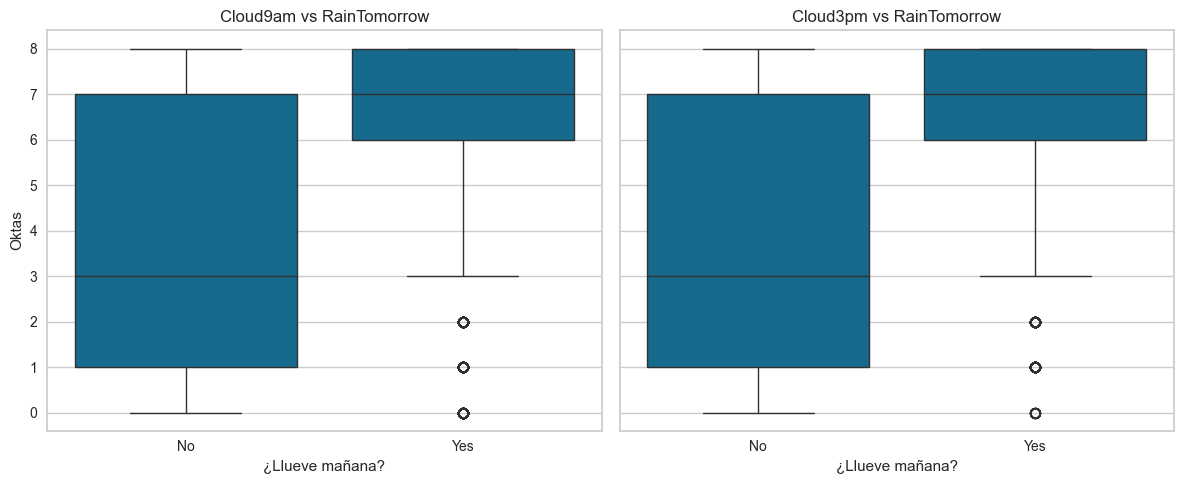

In [44]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

sns.boxplot(data=X_train.join(y_train), x='RainTomorrow', y='Cloud9am', ax=axes[0])
axes[0].set_title('Cloud9am vs RainTomorrow')

sns.boxplot(data=X_train.join(y_train), x='RainTomorrow', y='Cloud3pm', ax=axes[1])
axes[1].set_title('Cloud3pm vs RainTomorrow')

for ax in axes:
    ax.set_xlabel('¿Llueve mañana?')
    ax.set_ylabel('Oktas')

plt.tight_layout()
plt.show()

#### Varible Evaporación

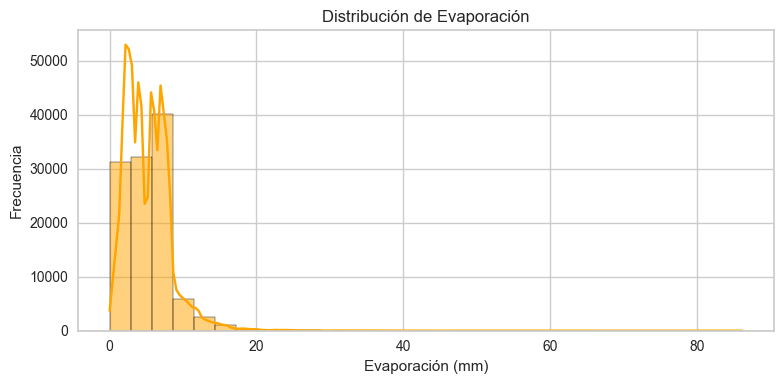

In [45]:
plt.figure(figsize=(8, 4))
sns.histplot(data=X_train, x='Evaporation', bins=30, color='orange', kde=True)
plt.title('Distribución de Evaporación')
plt.xlabel('Evaporación (mm)')
plt.ylabel('Frecuencia')
plt.tight_layout()
plt.show()


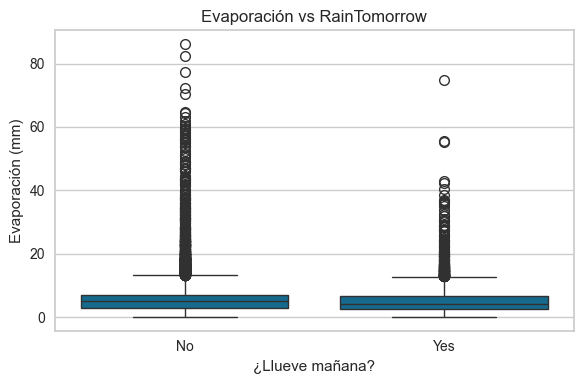

In [46]:
plt.figure(figsize=(6, 4))
sns.boxplot(data=X_train.join(y_train), x='RainTomorrow', y='Evaporation')
plt.title('Evaporación vs RainTomorrow')
plt.xlabel('¿Llueve mañana?')
plt.ylabel('Evaporación (mm)')
plt.tight_layout()
plt.show()

#### Variable Cantidad de lluvia

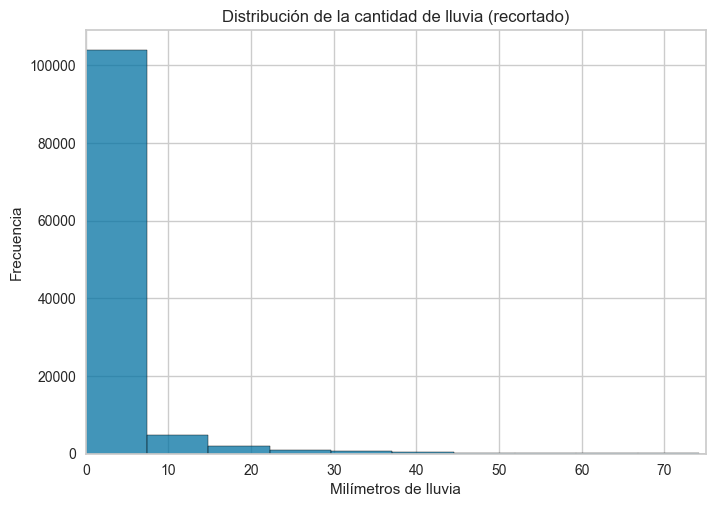

In [47]:
# Para mejor visualizacion se utilizaron hasta 75mm de lluvia
sns.histplot(X_train['Rainfall'], bins=50)
plt.xlim(0, 75)  
plt.title("Distribución de la cantidad de lluvia (recortado)")
plt.xlabel("Milímetros de lluvia")
plt.ylabel("Frecuencia")
plt.show()


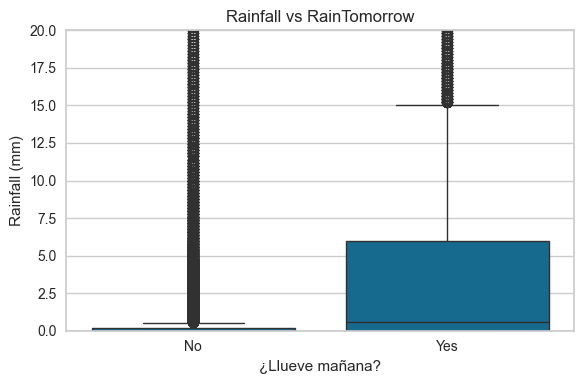

In [48]:
plt.figure(figsize=(6, 4))
sns.boxplot(data=X_train.join(y_train), x='RainTomorrow', y='Rainfall')
plt.ylim(0, 20)  # Acotamos para ver bien las diferencias
plt.title('Rainfall vs RainTomorrow')
plt.xlabel('¿Llueve mañana?')
plt.ylabel('Rainfall (mm)')
plt.tight_layout()
plt.show()

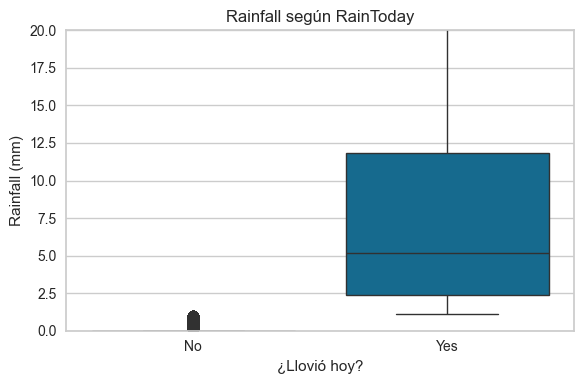

In [49]:
plt.figure(figsize=(6, 4))
sns.boxplot(data=X_train, x='RainToday', y='Rainfall')
plt.title('Rainfall según RainToday')
plt.xlabel('¿Llovió hoy?')
plt.ylabel('Rainfall (mm)')
plt.ylim(0, 20)  # acotamos para visualizar mejor
plt.tight_layout()
plt.show()

#### Matriz de correlación entre variables numéricas

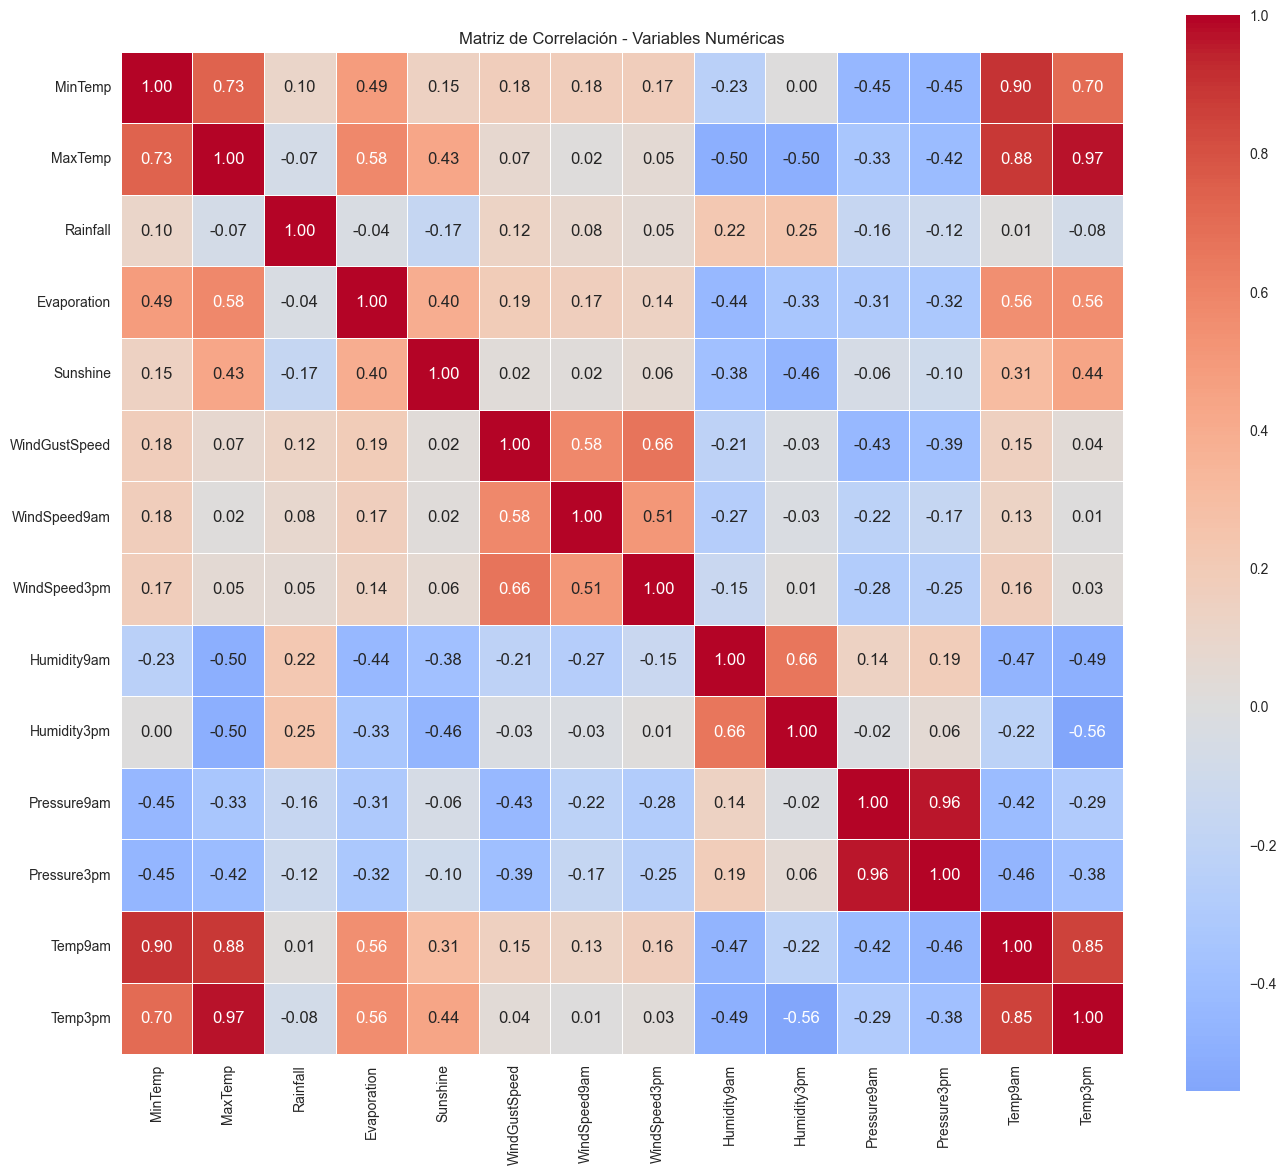

In [50]:
df_numeric = X_train[columnas_numericas].copy()

plt.figure(figsize=(14, 12))
corr_matrix = df_numeric.corr()
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', center=0, square=True, linewidths=0.5)
plt.title('Matriz de Correlación - Variables Numéricas')
plt.tight_layout()
plt.show()

### **Codificación de Variables**

In [51]:
# Columnas a aplicar one hot encoding
columnas_categoricas = [ 'RainToday', 'Region', 'Cloud9am', 'Cloud3pm', 'Month']

# Aplicamos one hot encoding al X_train
X_train_codificado = pd.get_dummies(X_train, columns=columnas_categoricas, drop_first=False)

In [52]:
# Aplicamos one hot encoding al X_test
X_test_codificado = pd.get_dummies(X_test, columns=columnas_categoricas, drop_first=False)

# Alineamos columnas de test con las de train (añadir ceros donde falte)
X_test_codificado = X_test_codificado.reindex(columns=X_train_codificado.columns, fill_value=0)

In [53]:
# Para representar correctamente la naturaleza circular de las direcciones, las convertimos en ángulos en grados 
# y luego aplicamos las funciones trigonométricas seno y coseno.

direccion_a_grados = {
    'N': 0, 'NNE': 22.5, 'NE': 45, 'ENE': 67.5,
    'E': 90, 'ESE': 112.5, 'SE': 135, 'SSE': 157.5,
    'S': 180, 'SSW': 202.5, 'SW': 225, 'WSW': 247.5,
    'W': 270, 'WNW': 292.5, 'NW': 315, 'NNW': 337.5
}

for df in [X_train_codificado, X_test_codificado]:
    df['WindGustDir_deg'] = df['WindGustDir'].map(direccion_a_grados)
    df['WindDir9am_deg'] = df['WindDir9am'].map(direccion_a_grados)
    df['WindDir3pm_deg'] = df['WindDir3pm'].map(direccion_a_grados)

for df in [X_train_codificado, X_test_codificado]:
    for col in ['WindGustDir_deg', 'WindDir9am_deg', 'WindDir3pm_deg']:
        df[f'{col}_sin'] = np.sin(np.deg2rad(df[col]))
        df[f'{col}_cos'] = np.cos(np.deg2rad(df[col]))


In [54]:
columnas_a_eliminar = ['WindGustDir', 'WindDir9am', 'WindDir3pm', 'WindGustDir_deg','WindDir9am_deg', 'WindDir3pm_deg',]
X_train_codificado = X_train_codificado.drop(columns=columnas_a_eliminar)
X_test_codificado = X_test_codificado.drop(columns=columnas_a_eliminar)

### **Escalado de Datos**

In [55]:
scaler = StandardScaler()

# Escalar solo las columnas numéricas
X_train_num_scaled = scaler.fit_transform(X_train_codificado[columnas_numericas])
X_test_num_scaled = scaler.transform(X_test_codificado[columnas_numericas])

# Crear nuevos DataFrames con los datos escalados
X_train_num_scaled_df = pd.DataFrame(X_train_num_scaled, columns=columnas_numericas, index=X_train_codificado.index)
X_test_num_scaled_df = pd.DataFrame(X_test_num_scaled, columns=columnas_numericas, index=X_test_codificado.index)

# Reemplazar las columnas numéricas originales por las escaladas
X_train_escalado = X_train_codificado.copy()
X_test_escalado = X_test_codificado.copy()

X_train_escalado[columnas_numericas] = X_train_num_scaled_df
X_test_escalado[columnas_numericas] = X_test_num_scaled_df

# Asegurar mismo orden y mismas columnas que en train
X_test_escalado = X_test_escalado.reindex(columns=X_train_escalado.columns, fill_value=0)



# **Ejercicio 3:** Regresión Logística y obtención de métricas
En esta sección entrenamos y evaluamos un modelo de **Regresión Logística** sobre los datos escalados.

In [56]:
def evaluate_and_store(name, model, X, y, results_dict):
    y_bin = (y == 'Yes').astype(int)
    y_pred = model.predict(X)
    y_pred_bin = (y_pred == 'Yes').astype(int)

    f1  = f1_score(y_bin, y_pred_bin)
    acc = accuracy_score(y_bin, y_pred_bin)
    recall = recall_score(y_bin, y_pred_bin)
    mcc = matthews_corrcoef(y_bin, y_pred_bin)

    results_dict[name] = [acc,f1, recall, mcc]
    return results_dict

Plynomial Features en columnas numéricas

In [57]:
# Aplicamos PolynomialFeatures solo a las columnas numéricas de ambas particiones
poly = PolynomialFeatures(degree=3, interaction_only=True, include_bias=False)
X_train_num = X_train_escalado[columnas_numericas]
X_test_num  = X_test_escalado[columnas_numericas]

X_train_poly = poly.fit_transform(X_train_num)
X_test_poly  = poly.transform(X_test_num)

# Reconstruimos el DataFrame con los nombres de las nuevas columnas polinómicas
cols_poly = poly.get_feature_names_out(columnas_numericas)
X_train_poly_df = pd.DataFrame(X_train_poly, columns=cols_poly, index=X_train_escalado.index)
X_test_poly_df  = pd.DataFrame(X_test_poly,  columns=cols_poly, index=X_test_escalado.index)

# Concatenamos con las variables dummies sin polinomios
cat_cols = [c for c in X_train_escalado.columns if c not in columnas_numericas]
X_train_final = pd.concat([X_train_poly_df, X_train_escalado[cat_cols]], axis=1)
X_test_final  = pd.concat([X_test_poly_df,  X_test_escalado[cat_cols]], axis=1)


#### Modelos de regresión logística y sus métricas

In [58]:
# Inicializamos resultados
resultados_balanceo = {}

# Modelo sin balanceo
model_original = LogisticRegression(random_state=42, max_iter=1000)
model_original.fit(X_train_final, y_train)
resultados_balanceo = evaluate_and_store('LogReg sin balanceo', model_original, X_test_final, y_test, resultados_balanceo)

# Modelo con class_weight='balanced'
model_weighted = LogisticRegression(random_state=42, max_iter=1000, class_weight='balanced')
model_weighted.fit(X_train_final, y_train)
resultados_balanceo = evaluate_and_store('LogReg class_weight=balanced', model_weighted, X_test_final, y_test, resultados_balanceo)

# Oversampling
ros = RandomOverSampler(random_state=42)
X_train_ros, y_train_ros = ros.fit_resample(X_train_final, y_train)
model_ros = LogisticRegression(random_state=42, max_iter=1000)
model_ros.fit(X_train_ros, y_train_ros)
resultados_balanceo = evaluate_and_store('LogReg + Oversampling', model_ros, X_test_final, y_test, resultados_balanceo)

# Undersampling
rus = RandomUnderSampler(random_state=42)
X_train_rus, y_train_rus = rus.fit_resample(X_train_final, y_train)
model_rus = LogisticRegression(random_state=42, max_iter=1000)
model_rus.fit(X_train_rus, y_train_rus)
resultados_balanceo = evaluate_and_store('LogReg + Undersampling', model_rus, X_test_final, y_test, resultados_balanceo)

# SMOTE
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_final, y_train)
model_smote = LogisticRegression(random_state=42, max_iter=1000)
model_smote.fit(X_train_smote, y_train_smote)
resultados_balanceo = evaluate_and_store('LogReg + SMOTE', model_smote, X_test_final, y_test, resultados_balanceo)

# Visualizar resultados
results = pd.DataFrame(resultados_balanceo, index=['Accuracy', 'F1', 'Recall', 'MCC']).T
results.sort_values(by='Recall', ascending=False)

,Accuracy,F1,Recall,MCC
LogReg + Undersampling,0.792576,0.629424,0.789790,0.513699
LogReg class_weight=balanced,0.794056,0.630954,0.789316,0.515721
LogReg + Oversampling,0.793880,0.630568,0.788683,0.515164
LogReg + SMOTE,0.848592,0.619406,0.552394,0.532733
LogReg sin balanceo,0.850108,0.608038,0.521258,0.529724


Observamos que el balanceo con **OverSampling** y **class_weight=balanced** tiene metricas similares. Si bien, observando Recall y F1, Oversampling tiene resultados levemente mejores, consideramos que es mejor el modelo con class_weight=balanced por su eficiencia y costo.

In [59]:
# Modelo más interpretable (sin polinomios)
model_simple = LogisticRegression(random_state=42, max_iter=1000, class_weight='balanced')
model_simple.fit(X_train_escalado, y_train)

# Evaluamos 
resultados_balanceo = evaluate_and_store('LogReg simple (para SHAP)', model_simple, X_test_escalado, y_test, resultados_balanceo)

# Mostrar tabla actualizada (con modelo simple)
results = pd.DataFrame(resultados_balanceo, index=['Accuracy', 'F1', 'Recall', 'MCC']).T
results.sort_values(by='Recall', ascending=False)


,Accuracy,F1,Recall,MCC
LogReg + Undersampling,0.792576,0.629424,0.789790,0.513699
LogReg class_weight=balanced,0.794056,0.630954,0.789316,0.515721
LogReg + Oversampling,0.793880,0.630568,0.788683,0.515164
LogReg simple (para SHAP),0.785243,0.617577,0.777462,0.496981
LogReg + SMOTE,0.848592,0.619406,0.552394,0.532733
LogReg sin balanceo,0.850108,0.608038,0.521258,0.529724


### Matrices de confusión 

In [60]:
# Diccionario de modelos y sus respectivos X
modelos = {
    'LogReg sin balanceo': (model_original, X_test_final),
    'LogReg class_weight=balanced': (model_weighted, X_test_final),
    'LogReg + Oversampling': (model_ros, X_test_final),
    'LogReg + Undersampling': (model_rus, X_test_final),
    'LogReg + SMOTE': (model_smote, X_test_final),
    'LogReg simple (para SHAP)': (model_simple, X_test_escalado),
}

# Binarizamos y_test una sola vez
y_test_bin = (y_test == 'Yes').astype(int)


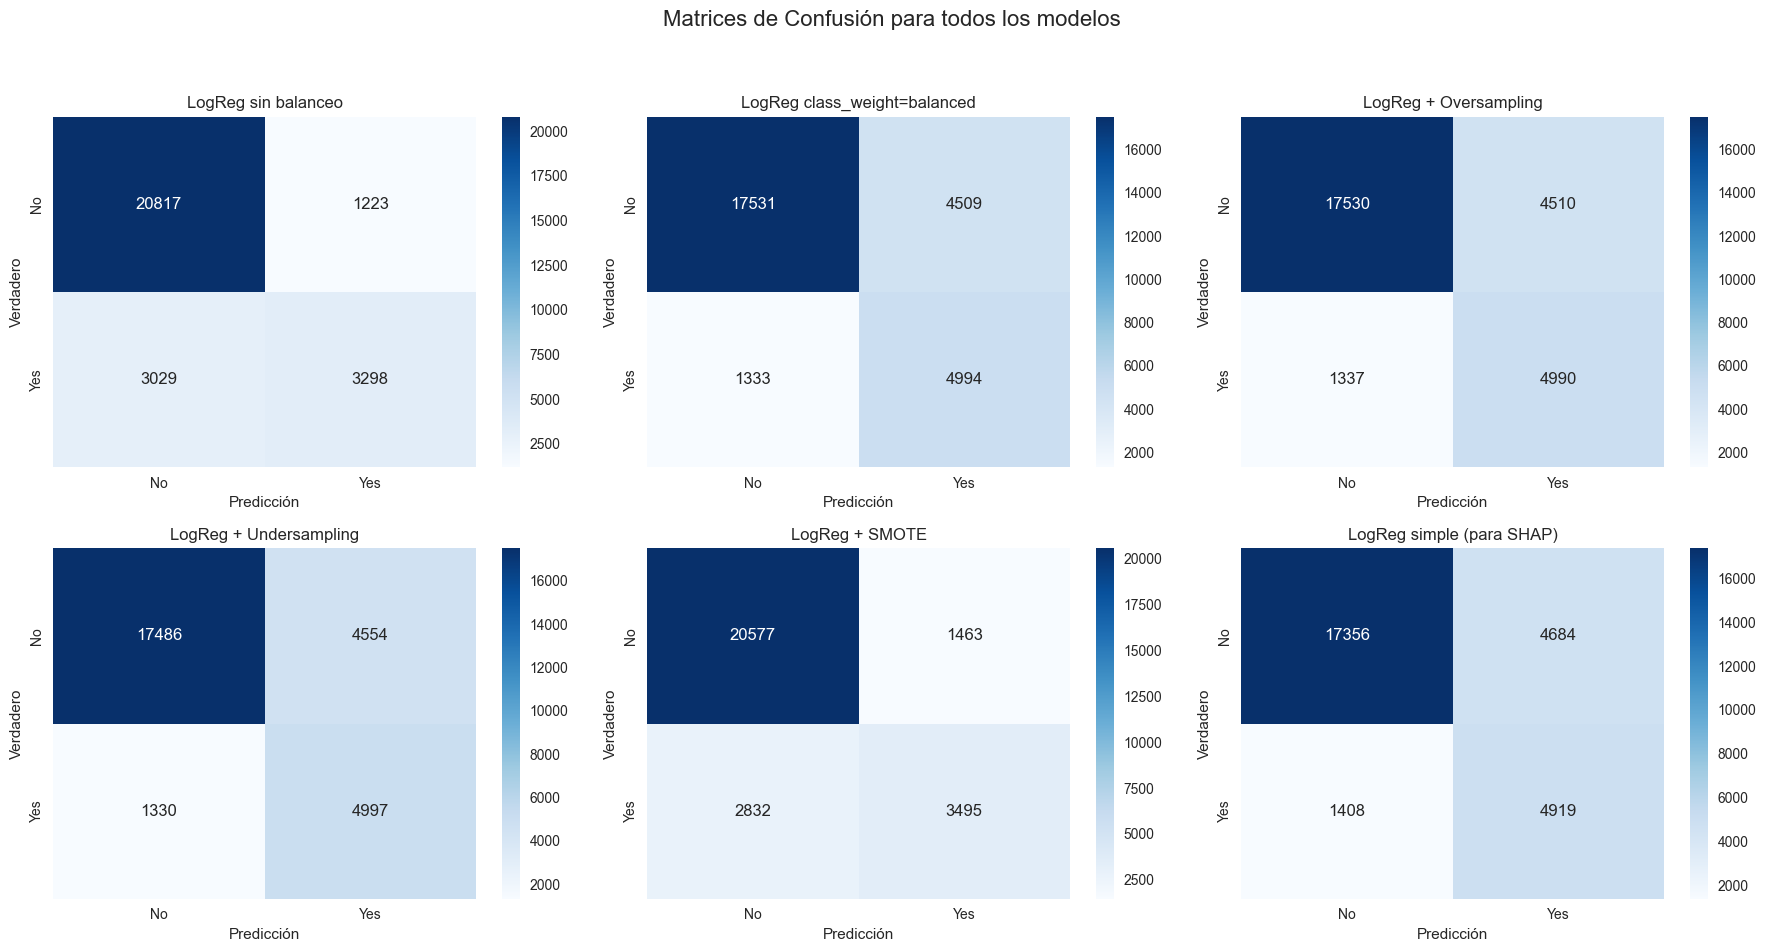

In [61]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.ravel()

for i, (nombre, (modelo, X_test)) in enumerate(modelos.items()):
    y_pred = modelo.predict(X_test)
    y_pred_bin = (y_pred == 'Yes').astype(int)

    cm = confusion_matrix(y_test_bin, y_pred_bin)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'],
                ax=axes[i])
    axes[i].set_title(nombre)
    axes[i].set_xlabel("Predicción")
    axes[i].set_ylabel("Verdadero")

plt.suptitle("Matrices de Confusión para todos los modelos", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


### Curvas ROC y cálculo de umbrales

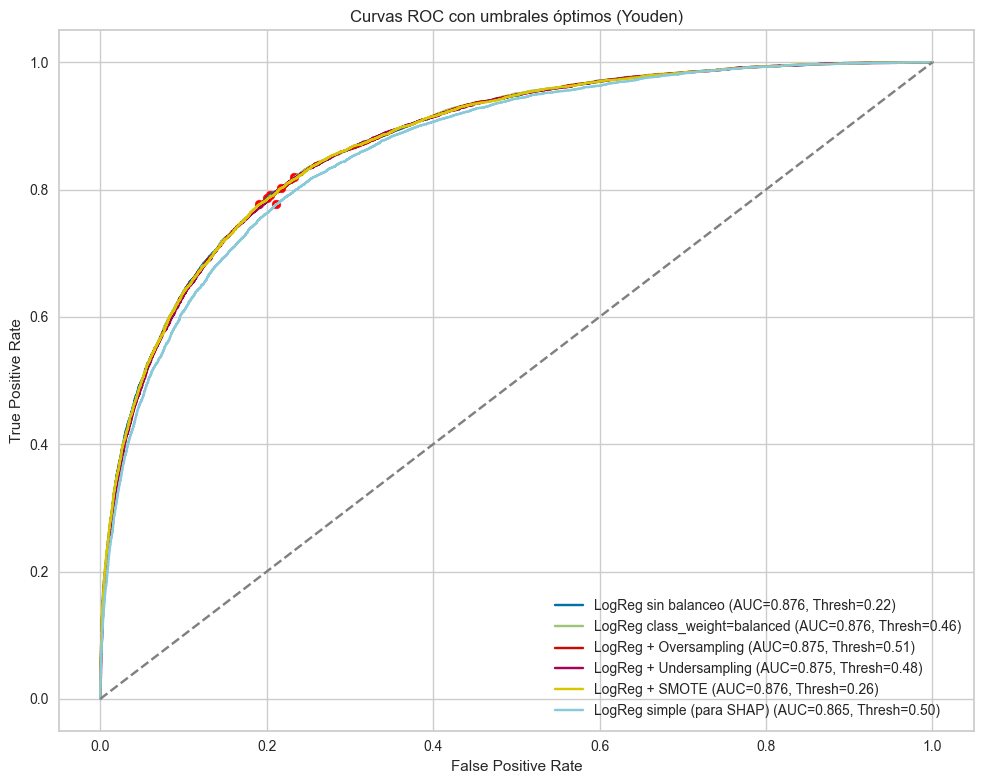

Umbrales óptimos calculados según el índice de Youden:
- LogReg sin balanceo: 0.224
- LogReg class_weight=balanced: 0.460
- LogReg + Oversampling: 0.505
- LogReg + Undersampling: 0.485
- LogReg + SMOTE: 0.260
- LogReg simple (para SHAP): 0.502


In [62]:
# Almacenamos umbrales óptimos
umbrales_optimos = {}


plt.figure(figsize=(10, 8))
for nombre, (modelo, X_test) in modelos.items():
    y_proba = modelo.predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test_bin, y_proba)
    roc_auc_val = auc(fpr, tpr)
    j_scores = tpr - fpr
    ix = np.argmax(j_scores)
    best_thresh = thresholds[ix]
    umbrales_optimos[nombre] = best_thresh

    plt.plot(fpr, tpr, label=f"{nombre} (AUC={roc_auc_val:.3f}, Thresh={best_thresh:.2f})")
    plt.scatter(fpr[ix], tpr[ix], marker='o', color='red', s=40)

plt.plot([0, 1], [0, 1], '--', color='grey')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curvas ROC con umbrales óptimos (Youden)')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

# Mostrar los umbrales óptimos
print("Umbrales óptimos calculados según el índice de Youden:")
for nombre, umbral in umbrales_optimos.items():
    print(f"- {nombre}: {umbral:.3f}")


**Análisis de falsos positivos y falsos negativos**  
- **Falso positivo (FP)**: Se predijo lluvia mañana, pero en realidad no llovió. Puede llevar a acciones innecesarias (llevar paraguas sin necesitarlo).  
- **Falso negativo (FN)**: No se predijo lluvia, pero sí llovió. Puede causar falta de preparación ante la lluvia (no llevar paraguas o piloto).  

Es preferible encontrar menos **falsos negativos**

**Selección de umbral**  
El umbral 0.5 es convencional, pero no siempre óptimo. Usando el índice de Youden se encuentra el umbral que maximiza TPR−FPR.  

**¿Buen fitting?**  
- Evaluando el modelo de regresion logistica con Plynonial Features y balanceo con class_eight=balanced, vemos que se consigue un buen fitting general. El F1 Score resultante indica un buen equilibrio entre Precisión y Recall. El AUC tiene un valor muy bueno, lo cual indica que tiene una alta capacidad para predecir correctamente. Por otra parte el MCC (que esta métrica es especialmente rigurosa en datasets desbalanceados) tiene un rendimiento moderado y equilibrado.
En conjunto, estas métricas permiten concluir que el modelo ha aprendido de manera adecuada los patrones del problema y generaliza correctamente sobre nuevos datos, logrando un fitting satisfactorio.

# **Ejercicio 4:** Modelo Base
En esta sección creamos y evaluamos un **Modelo Base** basandonos en un criterio ingenuo.

In [63]:
# Calculamos la proporción de clases en el conjunto de entrenamiento
proporcion_clases = y_train.value_counts(normalize=True)
proporcion_no_lluvia = proporcion_clases.loc["No"]  # Clase 0: No lluvia
proporcion_lluvia = proporcion_clases.loc["Yes"] # Clase 1: Lluvia

# Mostramos como porcentaje
print(f"Porcentaje de No lluvia: {proporcion_no_lluvia * 100:.2f}%")
print(f"Porcentaje de Lluvia: {proporcion_lluvia * 100:.2f}%")

Porcentaje de No lluvia: 77.57%
Porcentaje de Lluvia: 22.43%


In [64]:
# Predecimos la clase basandonos en el porcentaje. Al 77.57% predecimos que no llueve
# y al 22.43% predecimos que si llueve


# Generamos predicciones aleatorias sobre el conjunto de test, respetando las proporciones
np.random.seed(42)  # Semilla para reproducibilidad
predicciones_base = np.random.choice(
    ["No", "Yes"],                    # Clases posibles
    size=len(y_test),         # Tamaño del test
    p=[proporcion_no_lluvia, proporcion_lluvia]  # Probabilidades por clase
)


In [65]:
# Convertimos a binario para métricas adicionales
y_test_bin = (y_test == "Yes").astype(int)
pred_bin = (predicciones_base == "Yes").astype(int)

# Métricas 
f1 = f1_score(y_test_bin, pred_bin)
acc = accuracy_score(y_test_bin, pred_bin)
mcc = matthews_corrcoef(y_test_bin, pred_bin)
recall = recall_score(y_test_bin, pred_bin)
roc = roc_auc_score(y_test_bin, pred_bin)

resultados_balanceo["Modelo Base proporcional"] = [acc, f1, recall, mcc]

# Mostrar resultados
print(f"ROC AUC: {roc:.4f}")
results = pd.DataFrame(resultados_balanceo, index=['Accuracy', 'F1', 'Recall', 'MCC']).T
results.sort_values(by='Recall', ascending=False)


ROC AUC: 0.4999


,Accuracy,F1,Recall,MCC
LogReg + Undersampling,0.792576,0.629424,0.789790,0.513699
LogReg class_weight=balanced,0.794056,0.630954,0.789316,0.515721
LogReg + Oversampling,0.793880,0.630568,0.788683,0.515164
LogReg simple (para SHAP),0.785243,0.617577,0.777462,0.496981
LogReg + SMOTE,0.848592,0.619406,0.552394,0.532733
LogReg sin balanceo,0.850108,0.608038,0.521258,0.529724
Modelo Base proporcional,0.653400,0.222890,0.222854,-0.000149


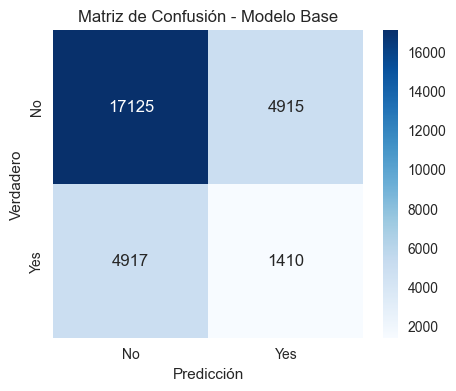

In [66]:
# Matriz de confusión visual
cm = confusion_matrix(y_test_bin, pred_bin)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No','Yes'], yticklabels=['No','Yes'])
plt.xlabel('Predicción')
plt.ylabel('Verdadero')
plt.title('Matriz de Confusión - Modelo Base')
plt.show()

#### Análisis de la Matriz de Confusion
- El modelo predice correctamente 17125 casos donde no llovió y 1410 casos donde sí llovió.
- Sin embargo, comete un número significativo de errores, con 4915 falsos positivos (predijo lluvia cuando no la hubo) y 4917 falsos negativos (predijo no lluvia cuando sí llovió).

#### Métricas de Desempeño 
- F1 Score = 0.223: Indica una baja capacidad del modelo para equilibrar precisión y recall en la clase positiva ("Lluvia").

- ROC AUC ≈ 0.5: El valor está prácticamente al nivel de un clasificador aleatorio, lo que significa que el modelo no tiene poder discriminativo.

- Matthews Correlation Coefficient (MCC) ≈ 0: También confirma que la predicción no es mejor que una elección al azar, dado que MCC varía entre -1 y 1, donde 0 indica ausencia de correlación entre predicción y verdad.




Este modelo base funciona como una referencia mínima para evaluar modelos más avanzados. Su desempeño pobre, cercano al azar, evidencia la necesidad de implementar modelos predictivos que aprovechen las variables y patrones presentes en los datos para mejorar la predicción de lluvia. La alta cantidad de falsos negativos y falsos positivos puede ser problemática para aplicaciones reales donde anticipar la lluvia es crucial.



### Probamos que hubiera pasado haciendo 50-50%

In [67]:
np.random.seed(42)  # Para reproducibilidad
predicciones_azar = np.random.choice(
    ["No", "Yes"],       # Clases posibles
    size=len(y_test),    # Tamaño del test
    p=[0.5, 0.5]         # Probabilidades iguales para ambas clases
)


=== Modelo base azar 50%-50% ===
F1 Score: 0.3118
ROC AUC: 0.4999
Accuracy: 0.5016
Matthews CorrCoef: 0.0055
Recall: 0.5062


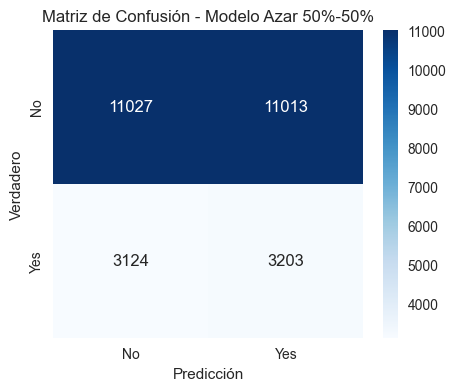

In [68]:
# Convertimos a binario para métricas
y_test_bin_azar = (y_test == "Yes").astype(int)
pred_bin_azar = (predicciones_azar == "Yes").astype(int)

# Métricas
f1 = f1_score(y_test_bin_azar, pred_bin_azar)
roc = roc_auc_score(y_test_bin, pred_bin)
acc = accuracy_score(y_test_bin_azar, pred_bin_azar)
mcc = matthews_corrcoef(y_test_bin_azar, pred_bin_azar)
recall = recall_score(y_test_bin_azar, pred_bin_azar)

print("=== Modelo base azar 50%-50% ===")
print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC: {roc:.4f}")
print(f"Accuracy: {acc:.4f}")
print(f"Matthews CorrCoef: {mcc:.4f}")
print(f"Recall: {recall:.4f}")

# Matriz de confusión visual
cm = confusion_matrix(y_test_bin_azar, pred_bin_azar)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No','Yes'], yticklabels=['No','Yes'])
plt.xlabel('Predicción')
plt.ylabel('Verdadero')
plt.title('Matriz de Confusión - Modelo Azar 50%-50%')
plt.show()


#### Análisis de la Matriz de Confusión 

- El modelo predice correctamente 11027 casos donde no llovió y 3203 casos donde sí llovió.

- Sin embargo, comete un número considerable de errores, con 11013 falsos positivos (predijo lluvia cuando no la hubo) y 3124 falsos negativos (predijo no lluvia cuando sí llovió).

#### Métricas de Desempeño 

- F1 Score = 0.312: Aunque es un poco mejor que el modelo que respeta la proporción original, sigue mostrando una baja capacidad para equilibrar precisión y recall en la clase positiva ("Lluvia").

- ROC AUC ≈ 0.503: Este valor cercano a 0.5 indica que el modelo no tiene poder discriminativo y funciona como un clasificador aleatorio.

- Matthews Correlation Coefficient (MCC) ≈ 0.0055: Confirma que la predicción es aleatoria, ya que MCC cerca de 0 indica ausencia de correlación entre predicción y verdad.

Este modelo con distribución equilibrada 50%-50% sirve como referencia básica para entender el desempeño de un clasificador sin información alguna. Su desempeño pobre y al azar refuerza la necesidad de desarrollar modelos que aprovechen las variables y patrones reales en los datos para predecir lluvia con mayor precisión. La gran cantidad de falsos positivos y falsos negativos dificulta su utilidad en aplicaciones donde anticipar la lluvia es crítico.



# **Ejercicio 5:** Optimizacion de Hiperparámetros


Técnicas como *Grid Search*, *Random Search* y Optuna no fueron una opción viable para el **Regresión Logística con Polynomial Features**, ya que requieren de mucho tiempo y poder de cómputo, llegando a tardar más de **300 minutos** sin completar la ejecución. 

Por este motivo, la selección de hiperparámetros para este modelo se realizó de forma **manual y razonada**:

- Se seleccionó `penalty='l2'` (*Ridge*) para **evitar el overfitting**, aunque con un valor de `C=10`, dado que el modelo no presentaba un nivel elevado de sobreajuste.
- Como `solver` se eligió `'lbfgs'`, ya que es más **eficiente computacionalmente** que `sag` y `newton-cg`, y fue el que mejores **resultados obtuvo en las métricas**.
- Se estableció `tol=0.001` como criterio de convergencia, lo cual representa un equilibrio adecuado entre **precisión y tiempo de entrenamiento**.
- Se utilizó `class_weight='balanced'` para **corregir el desbalance de clases** en el dataset, mejorando la sensibilidad hacia la clase minoritaria.

Esta configuración permitió obtener un modelo robusto y eficiente, adaptado a las restricciones de cómputo disponibles.

In [69]:
# Hiperparámetros
param_grid = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga']  
}

# GridSearch optimizando recall
grid_search_recall = GridSearchCV(
    estimator=LogisticRegression(random_state=42, max_iter=1000, class_weight='balanced'),
    param_grid=param_grid,
    scoring='recall',
    cv=5,
    n_jobs=-1,
    verbose=1
)

# Ejecutamos la búsqueda sobre el modelo simple (sin polinomios)
grid_search_recall.fit(X_train_escalado, y_train)

# Extraemos el mejor modelo según recall
best_lr_recall = grid_search_recall.best_estimator_

# Evaluamos
results = evaluate_and_store('LogReg Simple - H. Optimizados', best_lr_recall, X_test_escalado, y_test, resultados_balanceo)
pd.DataFrame(resultados_balanceo, index=['Accuracy', 'F1', 'Recall', 'MCC']).T.sort_values(by='Recall', ascending=False)


Fitting 5 folds for each of 16 candidates, totalling 80 fits


/Users/valentinrosito/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:993: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/valentinrosito/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 982, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/Users/valentinrosito/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 253, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/Users/valentinrosito/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 345, in _score
    y_pred = method_caller(
  File "/Users/valentinrosito/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 87, in _cached_call
    resul

,Accuracy,F1,Recall,MCC
LogReg + Undersampling,0.792576,0.629424,0.789790,0.513699
LogReg class_weight=balanced,0.794056,0.630954,0.789316,0.515721
LogReg + Oversampling,0.793880,0.630568,0.788683,0.515164
LogReg simple (para SHAP),0.785243,0.617577,0.777462,0.496981
LogReg Simple - H. Optimizados,0.786371,0.617907,0.774459,0.497268
LogReg + SMOTE,0.848592,0.619406,0.552394,0.532733
LogReg sin balanceo,0.850108,0.608038,0.521258,0.529724
Modelo Base proporcional,0.653400,0.222890,0.222854,-0.000149


Los mejores hiperparámetros para la regresión logística simple son:  
- Validación cruzada: 5 folds para cada uno de los 16 candidatos (80 ejecuciones en total)  
- Parámetros óptimos encontrados:  
    - **C**: 10  
    - **penalty**: l2  
    - **solver**: saga

# **Ejercicio 6:** SHAP. Explicabilidad de los Modelos


## SHAP para **Modelo de Regresión Logística simple**
------

En este caso, utilizamos SHAP para interpretar el modelo de regresión logística entrenado con class_weight='balanced' y sin características polinómicas por su simplicidad y porque mantiene una buena performance en recall.

### **Gráficos a nivel global**

**Gráfico enjambre de abejas**

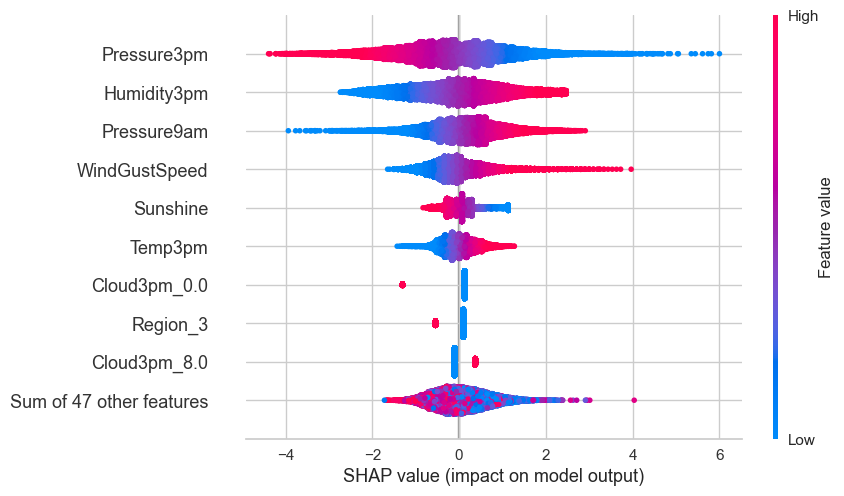

In [70]:
X_train_vals = X_train_escalado.to_numpy().astype(np.float64)
X_test_vals  = X_test_escalado.to_numpy().astype(np.float64)

explainer_lineal = shap.LinearExplainer(
    model_simple,
    X_train_vals,
    feature_perturbation="interventional"
)

shap_values = explainer_lineal.shap_values(X_test_vals)

feature_names = X_train_escalado.columns

explainer = shap.Explanation(
    values=shap_values,
    data=X_test_vals,
    feature_names=feature_names
)
shap.plots.beeswarm(explainer)

Observamos que las variables más importantes para la predicción son **Pressure3pm**, **Humidity3pm** y **Pressure9am**:
 - Cuanto menor es **Pressure 3pm**, más probabilidades hay de que llueva al día siguiente
 - Cuanto mayor es **Humidity 3pm**, mayor es la probabilidad de que llueva al día siguiente
 - Cuanto mayor es **Pressure9am**, mayor es la probabilidad de que llueva al día siguiente

**Grafico de valores medios de SHAP**

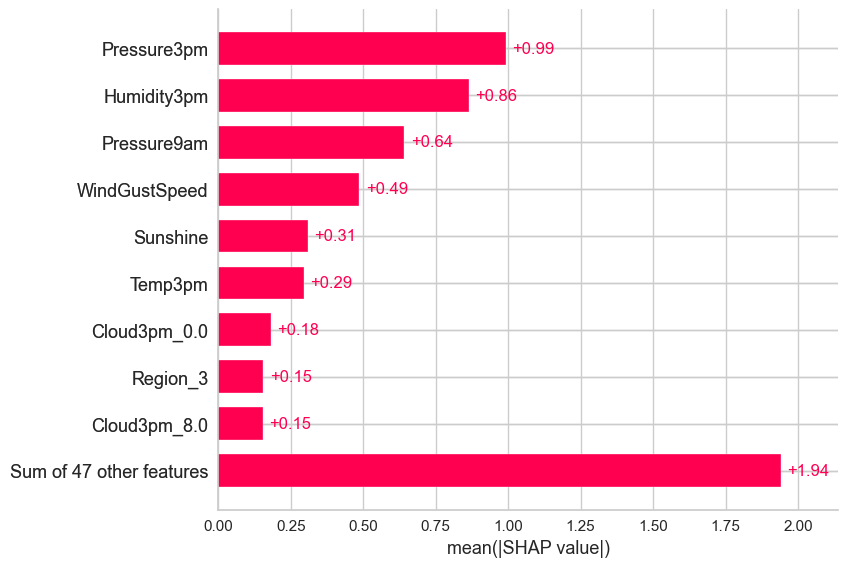

In [71]:
shap.plots.bar(explainer)


Cada barra indica cuánto, en promedio, aporta esa variable al modelo, sin importar signo. **Pressure3pm**, **Humidity3pm** y **Pressure9am** encabezan la lista lo que significa que son, globalmente, las tres variables cuyos cambios absolutos tienen mayor repercusión en las predicciones

### **Gráficos a nivel local**

**Force plot**

In [72]:
shap.initjs()
i = 0  # índice del ejemplo que quieras analizar
valor_base = explainer_lineal.expected_value  

# Extraemos el shap_vals de la clase positiva para el ejemplo i
shap_val_instancia = shap_values[i]

# Dibujar force plot
shap.plots.force(valor_base, shap_val_instancia, X_test_vals[i], feature_names=feature_names)

Este gráfico nos permite observar cómo influyen las variables del modelo sobre una determinada prediccion:

El modelo predujo un valor final de aproximadamente f(x) = −1.81, partiendo del valor base medio E[f(X)] = −0.643. 
Las flechas rojas (hacia la derecha) representan características que incrementan la predicción, y las azules (hacia la izquierda) representan las que la reducen. 

En este caso, **Pressure3pm**  y **Humidity3pm**  son las dos flechas azules más largas, por lo que empujan con mayor fuerza el log-odds hacia “clase negativa”. 
Otras variables, como **Pressure9am** y **Temp3pm**, van en sentido positivo, "empujando" hacia una prediccion positiva pero la suma de ellas y las demas en conjunto no alcanzan a contrarrestar el efecto negativo, lo que explica la predicción final, la cual es que no va a llover.

**Gráfico de cáscada**

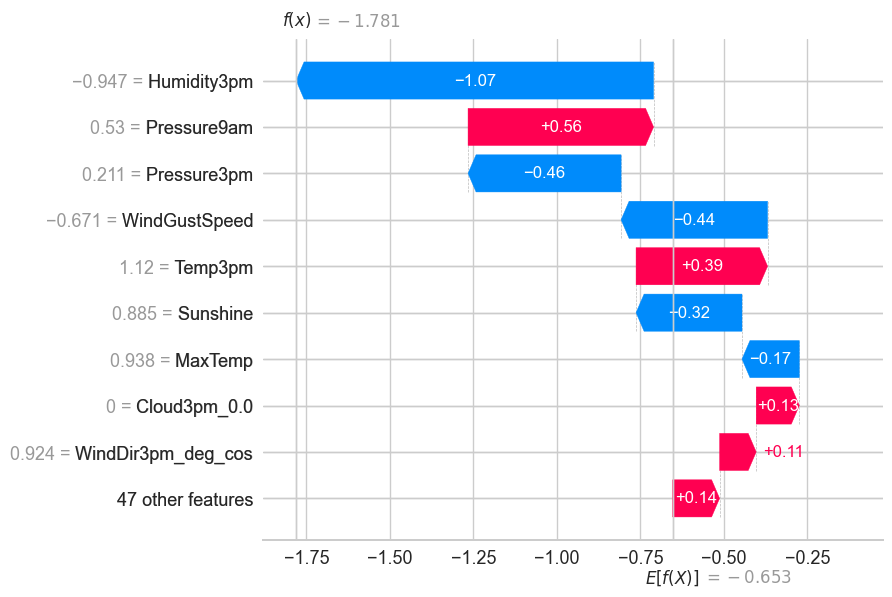

In [73]:
shap.plots.waterfall(shap.Explanation(
    values = shap_val_instancia,
    base_values = valor_base if np.isscalar(valor_base) else valor_base[1],
    data = X_test_vals[i],
    feature_names = feature_names
))

Este gráfico desglosa secuencialmente cada contributo SHAP de mayor a menor para la misma instancia explicada en el force plot. Comienza en el valor base E[f(X)] = −0.643 (barra de referencia) y a partir de allí muestra, fila por fila, cuánto suma o resta cada característica al score:

**Humidity3pm** = −0.947 contribuyó −1.07 (barra azul).

**Pressure9am** = 0.53 contribuyó +0.56 (barra roja).

**Pressure3pm** = 0.211 contribuyó −46 (barra azul).

--------

## SHAP para **Modelo de Regresión Logística con Polynomial Features**
--------

### **Gráficos a nivel global**

**Gráfico enjambre de abejas**

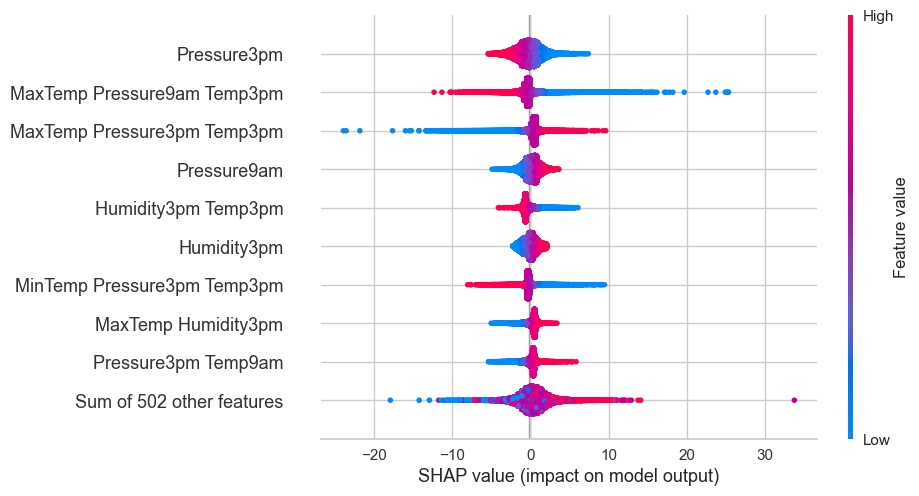

In [74]:
X_train_vals = X_train_final.to_numpy().astype(np.float64)
X_test_vals  = X_test_final.to_numpy().astype(np.float64)

explainer_lineal = shap.LinearExplainer(
    model_weighted,
    X_train_vals,
    feature_perturbation="interventional"
)

shap_values = explainer_lineal.shap_values(X_test_vals)

feature_names = X_train_final.columns

explainer = shap.Explanation(
    values=shap_values,
    data=X_test_vals,
    feature_names=feature_names
)
shap.plots.beeswarm(explainer)

Observamos que las variables que se situan mas arriba del gráfico son las que tienen mayor impacto en la prediccion, siendo estas **MaxTemp Pressure9am Temp3pm**, **Pressure 3pm**, **MaxTemp Pressure3pm Temp3pm**:
 - Cuanto menor es **MaxTemp Pressure9am Temp3pm**, mayor es la probabilidad de que llueva y, cuando es mayor es, menos probabilidades hay de que llueva
 - Cuanto menor es **Pressure 3pm**, más probabilidades hay de que llueva
 - Cuanto mayor es **MaxTemp Pressure3pm Temp3pm**, mayor es la probabilidad de que llueva

**Grafico de valores medios de SHAP**

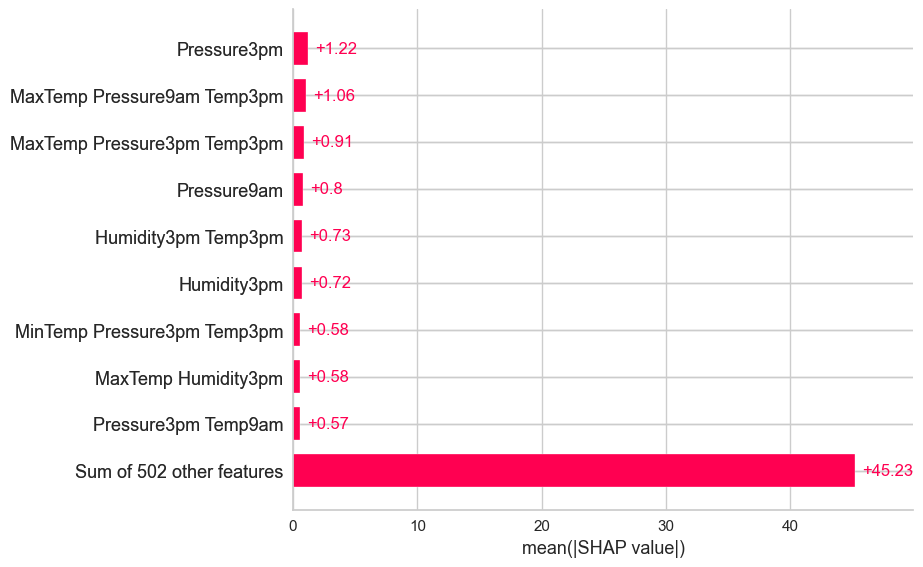

In [75]:
shap.plots.bar(explainer)

Cada barra indica cuánto, en promedio, aporta esa variable al modelo, sin importar signo. **MaxTemp Pressure9am Temp3pm** y **Pressure3pm** encabezan la lista estando por encima de +1, lo que significa que son, globalmente, las dos variables cuyos cambios absolutos tienen mayor repercusión en las predicciones. Sin embargo, podemos ver que la barra inferior es la que acumula más, estas son las 502 demas variables. 

Al ser tantas variables y que no pueden ser graficadas no nos parece un grafico significativo. 

### **Gráficos a nivel local**

**Force Plot**

In [76]:
i = 0  # índice del ejemplo que quieras analizar
valor_base = explainer_lineal.expected_value  

# Extraemos el shap_vals de la clase positiva para el ejemplo i
shap_val_instancia = shap_values[i]

# Dibujar force plot
shap.plots.force(valor_base, shap_val_instancia, X_test_vals[i], feature_names=feature_names)

En este ejemplo de prueba, el modelo produjo un valor final de aproximadamente f(x) = −1.98, partiendo del valor base medio E[f(X)] = −0.736. 
Las flechas rojas (hacia la derecha) representan características que incrementan la predicción, y las azules (hacia la izquierda) representan las que la reducen. En este caso, **MaxTemp Pressure9am Temp3pm**  y **Humidity3pm**  son las dos flechas azules más largas , por lo que empujan con mayor fuerza el log-odds hacia “clase negativa”. 
Otras variables, como **Pressure9am** y **MaxTemp Pressure3pm Temp3pm**, van en sentido positivo, pero en conjunto no alcanzan a contrarrestar el efecto negativo, lo que explica la predicción final.

**Gráfico de cascada**

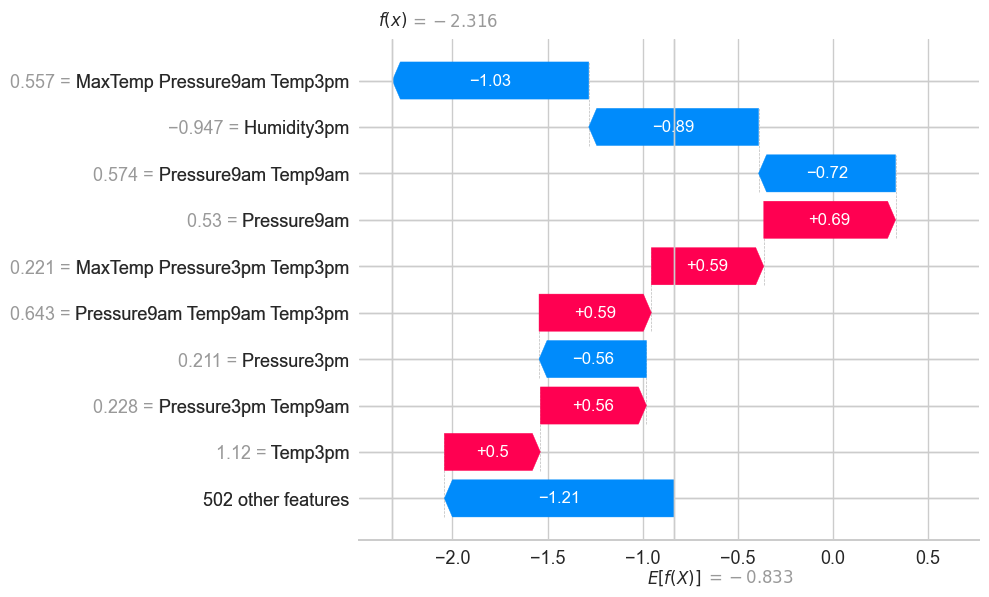

In [77]:
shap.plots.waterfall(shap.Explanation(
    values = shap_val_instancia,
    base_values = valor_base if np.isscalar(valor_base) else valor_base[1],
    data = X_test_vals[i],
    feature_names = feature_names
))

Este gráfico desglosa secuencialmente cada contributo SHAP de mayor a menor para la misma instancia explicada en el force plot. Comienza en el valor base E[f(X)] = −0.818 (barra de referencia) y a partir de allí muestra, fila por fila, cuánto suma o resta cada característica al score:

**MaxTemp Pressure9am Temp3pm** = 0.557 contribuyó −1 (barra azul).

**Humidity3pm** = −0.947 contribuyó −0.9 (barra azul).

**Pressure9am** = 0.53 contribuyó +0.69 (barra roja).

“502 otras” aportaron en total −1.23 (barra azul).

La suma acumulada de todas las barras lleva de −0.818 hasta f(x) ≈ −2.345, lo que justifica por qué el modelo asignó esa predicción negativa a este ejemplo: las dos primeras variables redujeron en conjunto el log-odds en cerca de −2.345 unidades, pese a que otras cuatro características aportaron algo de +0.60 cada una.



# **Ejercicio 7:** Modelo AutoML


In [78]:
# Volvemos a cargar el dataset original para usarlo con PyCaret
df_automl = pd.read_csv('weatherAUS.csv')

In [79]:
# Hacemos los mismos cambios de columnas que hicimos anteriormente (crear regiones, eliminar columnas de coordenadas y Location)

df_automl = pd.merge(df_automl, coord_df, on='Location', how='left')

# Aplicamos KMeans para crear columna 'Region'
X = df_automl[['Latitud', 'Longitud']]
kmeans = KMeans(n_clusters=4, random_state=42)
df_automl['Region'] = kmeans.fit_predict(X)

# Eliminamos columnas innecesarias
df_automl.drop(columns=['Latitud', 'Longitud', 'Location'], inplace=True)

# Converitmos la columna 'Date' a tipo datetime
#df_automl['Date'] = pd.to_datetime(df_automl['Date'], errors='coerce')


# Eliminamos filas con nulos en la variable target
df_automl = df_automl[df_automl['RainTomorrow'].notna()]

In [80]:
clf = setup(
    data=df_automl,  
    target='RainTomorrow',  # variable objetivo
    train_size=0.8, # Proporción de datos de entrenamiento
    session_id=42,
    verbose=True
)

best_model = compare_models()

,Description,Value
0,Session id,42
1,Target,RainTomorrow
2,Target type,Binary
3,Target mapping,"No: 0, Yes: 1"
4,Original data shape,"(142193, 23)"
5,Transformed data shape,"(142193, 68)"
6,Transformed train set shape,"(113754, 68)"
7,Transformed test set shape,"(28439, 68)"
8,Numeric features,17
9,Categorical features,5


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.8586,0.8936,0.8586,0.8512,0.8484,0.5420,0.5570,4.0320
lightgbm,Light Gradient Boosting Machine,0.8579,0.8906,0.8579,0.8504,0.8507,0.5539,0.5618,0.9990
et,Extra Trees Classifier,0.8572,0.8937,0.8572,0.8501,0.8454,0.5307,0.5496,4.6120
gbc,Gradient Boosting Classifier,0.8504,0.8791,0.8504,0.8414,0.8408,0.5208,0.5323,6.6630
lda,Linear Discriminant Analysis,0.8440,0.8694,0.8440,0.8343,0.8350,0.5050,0.5142,0.7500
lr,Logistic Regression,0.8434,0.8668,0.8434,0.8331,0.8326,0.4951,0.5075,3.5520
ridge,Ridge Classifier,0.8434,0.8694,0.8434,0.8335,0.8290,0.4788,0.4997,0.4790
ada,Ada Boost Classifier,0.8424,0.8654,0.8424,0.8323,0.8330,0.4986,0.5082,1.9790
knn,K Neighbors Classifier,0.8329,0.8137,0.8329,0.8218,0.8236,0.4714,0.4795,4.4610
dt,Decision Tree Classifier,0.7948,0.7086,0.7948,0.7963,0.7955,0.4143,0.4143,0.8870


[LightGBM] [Info] Number of positive: 22952, number of negative: 79426
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007032 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2897
[LightGBM] [Info] Number of data points in the train set: 102378, number of used features: 67
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.224189 -> initscore=-1.241421
[LightGBM] [Info] Start training from score -1.241421
[LightGBM] [Info] Number of positive: 22952, number of negative: 79426
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013260 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2895
[LightGBM] [Info] Number of data points in the train set: 102378, number of used features: 67
[LightGBM] [Info

Podemos observar que la librería PyCaret realiza automáticamente la preparación de datos, incluyendo la imputación de valores nulos y la codificación de variables categóricas. Esto simplifica considerablemente el flujo de trabajo y permite enfocarse en la selección, evaluación y ajuste de modelos, reduciendo la necesidad de realizar transformaciones manuales.

A pesar de que la ejecución tardó aproximadamente 11 minutos, el proceso automático logró identificar modelos con rendimientos muy buenos. En particular, el mejor modelo según el criterio de Recall fue el Random Forest Classifier.

Este modelo alcanzó una exactitud (accuracy) del 85.87% y un AUC de 0.8936, lo que indica una excelente capacidad para detectar correctamente los casos positivos. Además, obtuvo un F1-score de 84.84%, lo que refleja un buen equilibrio entre precisión y recall, y un MCC de 0.5569, que indica una sólida correlación entre las predicciones del modelo y los valores reales.


In [81]:
clf_2 = setup(
    data=df_automl,  
    target='RainTomorrow',  # variable objetivo
    train_size=0.8, # Proporción de datos de entrenamiento
    session_id=42,
    verbose=True,
    categorical_features=['Region', 'WindDir9am', 'WindDir3pm', 'WindGustDir'],
)

best_model_2 = compare_models()

,Description,Value
0,Session id,42
1,Target,RainTomorrow
2,Target type,Binary
3,Target mapping,"No: 0, Yes: 1"
4,Original data shape,"(142193, 23)"
5,Transformed data shape,"(142193, 71)"
6,Transformed train set shape,"(113754, 71)"
7,Transformed test set shape,"(28439, 71)"
8,Numeric features,16
9,Categorical features,4


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.8634,0.8988,0.8634,0.8565,0.8567,0.5723,0.5799,1.1450
dummy,Dummy Classifier,0.7758,0.5000,0.7758,0.6019,0.6779,0.0000,0.0000,0.3320


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 22952, number of negative: 79426
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012747 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5709
[LightGBM] [Info] Number of data points in the train set: 102378, number of used features: 70
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.224189 -> initscore=-1.241421
[LightGBM] [Info] Start training from score -1.241421
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large n

En este caso probamos configurando el modelo con más parámetros, definiendo explícitamente las features categóricas (Region, WindDir9am, WindDir3pm, WindGustDir). Esto permitió que PyCaret aplicara un tratamiento más preciso a los distintos tipos de variables durante el preprocesamiento.

En cuanto al rendimiento, el modelo seleccionado fue Light Gradient Boosting Machine, con métricas prácticamente idénticas a las obtenidas en la ejecución anterior, incluso un poco mejores: un F1 del 84.76%, AUC de 0.8870, y un recall de 85.68%. Esto confirma la consistencia del modelo en términos de desempeño.

La principal diferencia fue en el tiempo de ejecución, que se redujo significativamente a aproximadamente 3 minutos, comparado con los 11 minutos del experimento anterior. Esto sugiere que una configuración adecuada del setup() no solo mejora la claridad en el procesamiento de los datos, sino que también puede optimizar el tiempo total del flujo de trabajo.

In [82]:
results['AutoML - PyCaret (LightGBM)'] = [0.8634, 0.8567, 0.8634, 0.5799]
pd.DataFrame(resultados_balanceo, index=['Accuracy', 'F1', 'Recall', 'MCC']).T.sort_values(by='Recall', ascending=False)


,Accuracy,F1,Recall,MCC
AutoML - PyCaret (LightGBM),0.863400,0.856700,0.863400,0.579900
LogReg + Undersampling,0.792576,0.629424,0.789790,0.513699
LogReg class_weight=balanced,0.794056,0.630954,0.789316,0.515721
LogReg + Oversampling,0.793880,0.630568,0.788683,0.515164
LogReg simple (para SHAP),0.785243,0.617577,0.777462,0.496981
LogReg Simple - H. Optimizados,0.786371,0.617907,0.774459,0.497268
LogReg + SMOTE,0.848592,0.619406,0.552394,0.532733
LogReg sin balanceo,0.850108,0.608038,0.521258,0.529724
Modelo Base proporcional,0.653400,0.222890,0.222854,-0.000149


# **Ejercicio 8** - Neural Netwoks

In [83]:
# ————— Celda 0: configuración inicial —————
import os
# Menos logs de TensorFlow
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
# Desactivar flags XLA por si acaso
os.environ['TF_XLA_FLAGS'] = '--tf_xla_enable_xla_devices=false'

import tensorflow as tf

# Detectar GPU (Metal en Mac M1)
gpus = tf.config.list_physical_devices('GPU')
print("GPUs detectadas:", gpus)
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

# Asegurarnos de que XLA JIT esté **desactivado**
tf.config.optimizer.set_jit(False)

GPUs detectadas: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [84]:
"""""
# Convertir los datos (X, y) 
X = X_train_escalado.values.astype(np.float32)
y = (y_train == 'Yes').astype(int).values.reshape(-1,1).astype(np.float32)

# Métrica Recall personalizada para Keras
class RecallScore(tf.keras.metrics.Metric):
    def __init__(self, name='recall', threshold=0.5, **kwargs):
        super().__init__(name=name, **kwargs)
        self.threshold = threshold
        self.tp = self.add_weight(name='tp', initializer='zeros')
        self.fn = self.add_weight(name='fn', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred_bin = tf.cast(y_pred >= self.threshold, tf.float32)
        y_true_f = tf.cast(y_true, tf.float32)
        self.tp.assign_add(tf.reduce_sum(y_true_f * y_pred_bin))
        self.fn.assign_add(tf.reduce_sum(y_true_f * (1 - y_pred_bin)))

    def result(self):
        eps = tf.keras.backend.epsilon()
        return self.tp / (self.tp + self.fn + eps)

    def reset_states(self):
        self.tp.assign(0)
        self.fn.assign(0)

# Función objetivo para Optuna optimizando recall y con balanceo
def objective(trial):
    # Hiperparámetros a optimizar
    n_layers     = trial.suggest_int("n_layers", 1, 4)
    units        = trial.suggest_int("units", 16, 128, step=16)
    dropout_rate = trial.suggest_float("dropout", 0.0, 0.5)
    lr           = trial.suggest_loguniform("lr", 1e-4, 1e-2)
    batch_size   = trial.suggest_categorical("batch_size", [32, 64, 128])
    epochs       = trial.suggest_int("epochs", 20, 100, step=10)
    threshold    = trial.suggest_float("threshold", 0.3, 0.7, step=0.05)

    # Split
    X_tr, X_val, y_tr, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

    # Calcular pesos para balancear clases en train
    y_tr_ravel = y_tr.ravel()
    weights = class_weight.compute_class_weight(class_weight='balanced',
                                                classes=np.unique(y_tr_ravel),
                                                y=y_tr_ravel)
    class_weights_dict = dict(enumerate(weights))

    # Crear modelo
    model = Sequential()
    for i in range(n_layers):
        if i == 0:
            model.add(Dense(units, activation='relu', input_shape=(X.shape[1],)))
        else:
            model.add(Dense(units, activation='relu'))
        if dropout_rate > 0:
            model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(
        optimizer=Adam(learning_rate=lr),
        loss='binary_crossentropy',
        metrics=[RecallScore(threshold=threshold)]
    )

    es = EarlyStopping(patience=5, restore_best_weights=True)

    model.fit(
        X_tr, y_tr,
        validation_data=(X_val, y_val),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=[es],
        verbose=0,
        class_weight=class_weights_dict  # <-- Balanceo aquí
    )

    # Evaluar recall en validación
    loss, recall = model.evaluate(X_val, y_val, verbose=0)
    return recall

# Crear el estudio
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

print("Best params:", study.best_params)
print("Best Recall:", study.best_value)
"""

'""\n# Convertir los datos (X, y) \nX = X_train_escalado.values.astype(np.float32)\ny = (y_train == \'Yes\').astype(int).values.reshape(-1,1).astype(np.float32)\n\n# Métrica Recall personalizada para Keras\nclass RecallScore(tf.keras.metrics.Metric):\n    def __init__(self, name=\'recall\', threshold=0.5, **kwargs):\n        super().__init__(name=name, **kwargs)\n        self.threshold = threshold\n        self.tp = self.add_weight(name=\'tp\', initializer=\'zeros\')\n        self.fn = self.add_weight(name=\'fn\', initializer=\'zeros\')\n\n    def update_state(self, y_true, y_pred, sample_weight=None):\n        y_pred_bin = tf.cast(y_pred >= self.threshold, tf.float32)\n        y_true_f = tf.cast(y_true, tf.float32)\n        self.tp.assign_add(tf.reduce_sum(y_true_f * y_pred_bin))\n        self.fn.assign_add(tf.reduce_sum(y_true_f * (1 - y_pred_bin)))\n\n    def result(self):\n        eps = tf.keras.backend.epsilon()\n        return self.tp / (self.tp + self.fn + eps)\n\n    def reset_

Este código lo comentamos porque tarda más de *40 minutos en ejecutarse*. El mismo realizo 49 trials y **los mejores hiperparámetros y la mejor métrica de Recall** fueron:
- Best params: {'n_layers': 3, 'units': 64, 'dropout': 0.4185021628721507, 'lr': 0.00018360278947276526, 'batch_size': 128, 'epochs': 20, 'threshold': 0.3}
- Best Recall: 0.9326384663581848

Epoch 1/40
710/710 ━━━━━━━━━━━━━━━━━━━━ 14s 18ms/step - accuracy: 0.6402 - loss: 0.7013 - recall: 0.6725 - val_accuracy: 0.7612 - val_loss: 0.4988 - val_recall: 0.7909
Epoch 2/40
710/710 ━━━━━━━━━━━━━━━━━━━━ 12s 17ms/step - accuracy: 0.7235 - loss: 0.5711 - recall: 0.7338 - val_accuracy: 0.7679 - val_loss: 0.4887 - val_recall: 0.7905
Epoch 3/40
710/710 ━━━━━━━━━━━━━━━━━━━━ 12s 17ms/step - accuracy: 0.7415 - loss: 0.5397 - recall: 0.7388 - val_accuracy: 0.7704 - val_loss: 0.4834 - val_recall: 0.7889
Epoch 4/40
710/710 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - accuracy: 0.7527 - loss: 0.5197 - recall: 0.7525 - val_accuracy: 0.7721 - val_loss: 0.4792 - val_recall: 0.7855
Epoch 5/40
710/710 ━━━━━━━━━━━━━━━━━━━━ 12s 17ms/step - accuracy: 0.7605 - loss: 0.5073 - recall: 0.7584 - val_accuracy: 0.7728 - val_loss: 0.4772 - val_recall: 0.7847
Epoch 6/40
710/710 ━━━━━━━━━━━━━━━━━━━━ 12s 17ms/step - accuracy: 0.7648 - loss: 0.4984 - recall: 0.7574 - val_accuracy: 0.7740 - val_loss: 0.4754 - val_recall:

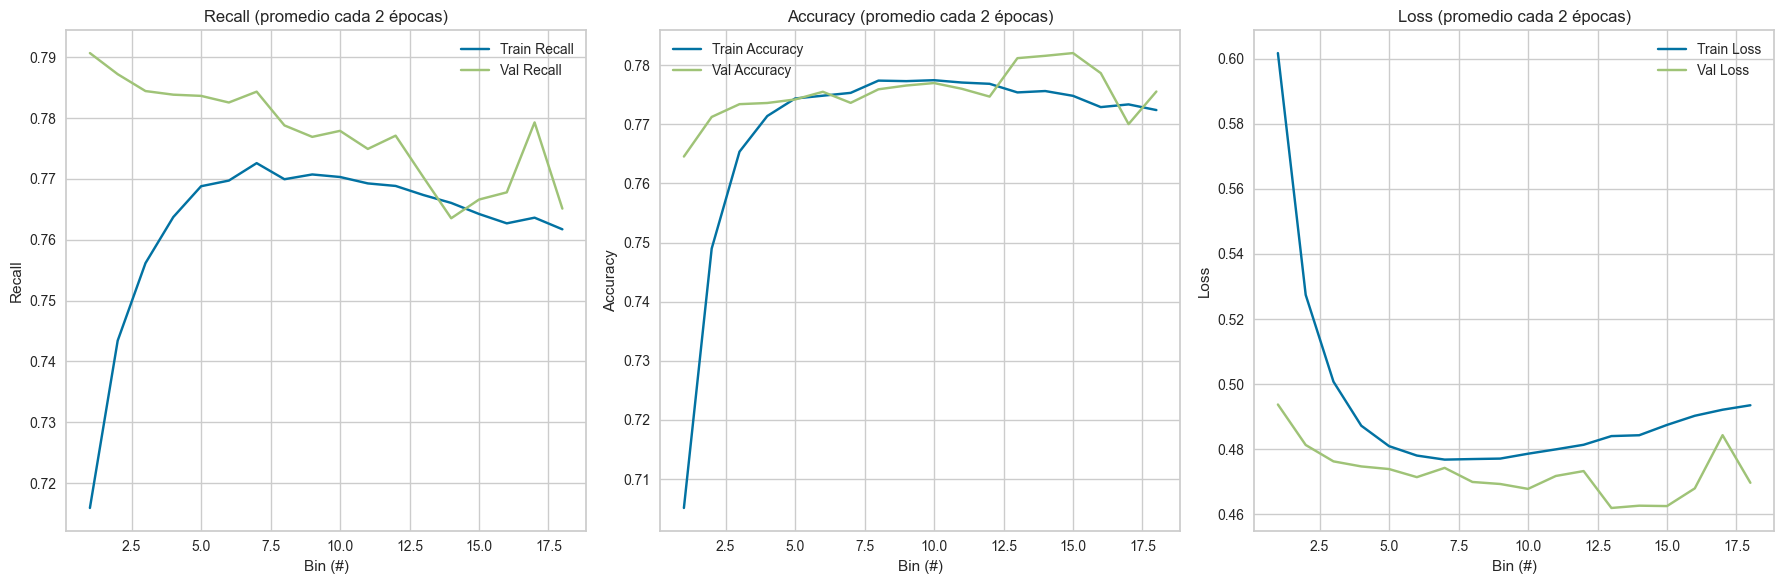

In [85]:
# 1) Prepara datos -------------------------------------------------------
y_train_bin = (y_train == 'Yes').astype(int).values.reshape(-1, 1).astype(np.float32)
y_test_bin  = (y_test  == 'Yes').astype(int).values.reshape(-1, 1).astype(np.float32)
X_train_np  = X_train_escalado.values.astype(np.float32)
X_test_np   = X_test_escalado.values.astype(np.float32)

# 2) Aplicar mejores hiperparámetros y volver a entrenar ----------------
best_params = {
    'n_layers': 3,
    'units': 64,
    'dropout': 0.4185021628721507,
    'lr': 0.00018360278947276526,
    'batch_size': 128,
    'epochs': 40,
    'threshold': 0.3
}

# 3) Reconstrucción del modelo ------------------------------------------
tf.random.set_seed(42)
mlp_tuned = Sequential()
for _ in range(best_params['n_layers']):
    mlp_tuned.add(Dense(best_params['units'], activation='relu'))
    mlp_tuned.add(Dropout(best_params['dropout']))
mlp_tuned.add(Dense(1, activation='sigmoid'))

optimizer = tf.keras.optimizers.Adam(
    learning_rate=best_params['lr'],
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,
    amsgrad=False
)

mlp_tuned.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Recall(name='recall')]
)

# 4) Entrenamiento ------------------------------------------------------

# Calcular class_weight para balancear clases
y_train_flat = y_train_bin.ravel()
weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train_flat), y=y_train_flat)
class_weights_dict = dict(enumerate(weights))

es_tuned = EarlyStopping(patience=5, restore_best_weights=True)
hist_tuned = mlp_tuned.fit(
    X_train_np,
    y_train_bin,
    validation_split=0.2,
    epochs=best_params['epochs'],
    batch_size=best_params['batch_size'],
    callbacks=[es_tuned],
    verbose=1,
    class_weight=class_weights_dict  # <--- Balanceo aplicado
)

# 5) Evaluación ---------------------------------------------------------
y_pred_proba = mlp_tuned.predict(X_test_np)
y_pred_bin = (y_pred_proba >= best_params['threshold']).astype(int)

# Métricas finales
acc    = accuracy_score(y_test_bin, y_pred_bin)
f1     = f1_score(y_test_bin, y_pred_bin)
recall = recall_score(y_test_bin, y_pred_bin)
mcc    = matthews_corrcoef(y_test_bin, y_pred_bin)

# Agregar resultados al DataFrame
results['MLP Tuned'] = [acc, f1, recall, mcc]  # None porque quitamos F1

# 6) Visualización ------------------------------------------------------
train_acc  = hist_tuned.history['accuracy']
val_acc    = hist_tuned.history['val_accuracy']
train_rec  = hist_tuned.history['recall']
val_rec    = hist_tuned.history['val_recall']
train_loss = hist_tuned.history['loss']
val_loss   = hist_tuned.history['val_loss']

def bin_every_n(values, n=2):
    return [np.mean(values[i:i+n]) for i in range(0, len(values), n)]

# Aplicar binning cada 2 épocas
train_rec_binned = bin_every_n(train_rec, n=2)
val_rec_binned   = bin_every_n(val_rec, n=2)
train_acc_binned = bin_every_n(train_acc, n=2)
val_acc_binned   = bin_every_n(val_acc, n=2)
train_loss_binned = bin_every_n(train_loss, n=2)
val_loss_binned   = bin_every_n(val_loss, n=2)

# Ejes x ajustados al binning
epochs_binned = list(range(1, len(train_rec_binned)+1))

# Plot
plt.figure(figsize=(18, 6))

# Plot Recall
plt.subplot(1, 3, 1)
plt.plot(epochs_binned, train_rec_binned, label='Train Recall')
plt.plot(epochs_binned, val_rec_binned, label='Val Recall')
plt.title('Recall (promedio cada 2 épocas)')
plt.xlabel('Bin (#)')
plt.ylabel('Recall')
plt.legend()

# Plot Accuracy
plt.subplot(1, 3, 2)
plt.plot(epochs_binned, train_acc_binned, label='Train Accuracy')
plt.plot(epochs_binned, val_acc_binned, label='Val Accuracy')
plt.title('Accuracy (promedio cada 2 épocas)')
plt.xlabel('Bin (#)')
plt.ylabel('Accuracy')
plt.legend()

# Plot Loss
plt.subplot(1, 3, 3)
plt.plot(epochs_binned, train_loss_binned, label='Train Loss')
plt.plot(epochs_binned, val_loss_binned, label='Val Loss')
plt.title('Loss (promedio cada 2 épocas)')
plt.xlabel('Bin (#)')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# **Ejercicio 9** - Comparación de Modelos
------

In [86]:
pd.DataFrame(resultados_balanceo, index=['Accuracy', 'F1', 'Recall', 'MCC']).T.sort_values(by='Recall', ascending=False)

,Accuracy,F1,Recall,MCC
MLP Tuned,0.638735,0.531670,0.919393,0.399475
AutoML - PyCaret (LightGBM),0.863400,0.856700,0.863400,0.579900
LogReg + Undersampling,0.792576,0.629424,0.789790,0.513699
LogReg class_weight=balanced,0.794056,0.630954,0.789316,0.515721
LogReg + Oversampling,0.793880,0.630568,0.788683,0.515164
LogReg simple (para SHAP),0.785243,0.617577,0.777462,0.496981
LogReg Simple - H. Optimizados,0.786371,0.617907,0.774459,0.497268
LogReg + SMOTE,0.848592,0.619406,0.552394,0.532733
LogReg sin balanceo,0.850108,0.608038,0.521258,0.529724
Modelo Base proporcional,0.653400,0.222890,0.222854,-0.000149


Para comparar los distintos modelos de clasificación y seleccionar el más adecuado, decidimos utilizar la métrica recall como criterio principal. Esto se debe a que nuestro problema consiste en predecir si lloverá al día siguiente, y el costo de no anticipar correctamente una lluvia (falso negativo) es significativamente mayor que el de predecir una lluvia que finalmente no ocurre (falso positivo).

Un falso negativo en este contexto implica que el modelo predijo que no iba a llover cuando en realidad sí llovió. Este tipo de error puede tener consecuencias importantes, ya que podría llevar a que las personas salgan sin protección adecuada (como paraguas o ropa impermeable), afectando actividades al aire libre, traslados, cultivos, eventos o incluso operaciones logísticas.

Por otro lado, un falso positivo (predecir lluvia cuando no llueve) puede resultar molesto, pero es menos grave en comparación. Por ejemplo, alguien podría llevar paraguas innecesariamente, lo cual representa una pequeña incomodidad.

La métrica recall (sensibilidad) se enfoca justamente en minimizar los falsos negativos, ya que mide la proporción de verdaderos positivos detectados respecto al total de positivos reales. 

# **Ejercicio 11** - Conclusión
------

**El objetivo principal de este trabajo** fue desarrollar un modelo de *machine learning* capaz de predecir si lloverá al día siguiente, priorizando la métrica de **recall** como criterio principal de evaluación. Esta elección se fundamenta en que un *falso negativo* —es decir, predecir que no lloverá cuando en realidad sí ocurre— puede generar consecuencias significativas en la vida cotidiana, como afectar traslados, actividades al aire libre, cultivos, eventos o logística. En contraste, un *falso positivo* representa una molestia menor, como llevar un paraguas innecesariamente.

A lo largo del proyecto se evaluaron múltiples enfoques, incluyendo:

- **Regresión logística** con distintas estrategias de balanceo (*SMOTE*, *Random Undersampling*, *Random Oversampling*, `class_weight='balanced'`)
- **Modelo AutoML** (*LightGBM*)
- **Red neuronal MLP** con hiperparámetros optimizados

Si bien el modelo **MLP Tuned** logró uno de los valores de *recall* más altos, su precisión y *F1-score* fueron considerablemente más bajos, lo cual indica una **alta tasa de falsos positivos**.

El modelo obtenido mediante **AutoML (LightGBM)** fue el que arrojó las mejores métricas generales. Sin embargo, fue descartado para producción debido a su *complejidad computacional* y el ***alto costo en recursos*** que implica utilizar un enfoque AutoML, el cual entrena y evalúa múltiples modelos en busca del óptimo.

Tampoco se eligió el modelo de regresión logística con *random undersampling*, ya que esta técnica reduce la cantidad de registros de la clase mayoritaria, provocando **pérdida de información** que podría ser valiosa para generar un modelo más robusto y generalizable. En el caso del *oversampling*, el modelo al ver muchas veces las mismas muestras tiende a *memorizar* esos ejemplos en lugar de ***aprender generalizaciones útiles***.

**Finalmente, se seleccionó para producción el modelo de Regresión Logística que utiliza Polynomial Features con `class_weight='balanced'`.**  
Este modelo ofrece:

- Un equilibrio razonable entre *recall*, Accuracy, simplicidad e interpretabilidad
- Bajo riesgo de *overfitting*
- Implementación eficiente en términos de tiempo y recursos

Por todo esto, se considera una opción *práctica y adecuada* para su despliegue en entornos reales.